# Python code for Seizing Opportunity: Maintenance Optimization in Offshore Wind Farms Considering Accessibility, Production and Crew Dispatch

This notebook contains the code used by **HOST**, a maintenance scheduling decision-support tool for offshore wind farm operators, proposed by Petros Papadopoulos, Dr. Ahmed A. Ezzat and Dr. David W. Coit in the paper *Seizing Opportunity: Maintenance Optimization in Offshore Wind Farms Considering Accessibility, Production, and Crew Dispatch*, submitted in the IEEE Transactions on Sustainable Energy journal for publication (under review). Manuscript link: https://arxiv.org/abs/2012.00213.

**Abstract:**

Operations and Maintenance (O\&M) constitute a major contributor to offshore wind's cost of energy. Due to the harsh and remote environment in which offshore turbines operate, 
there has been a growing interest in *opportunistic* maintenance scheduling for offshore wind farms, wherein grouping maintenance tasks is incentivized at times of opportunity. Our survey of the literature, however, reveals that there is no unified consensus on what constitutes an "opportunity" for offshore maintenance. We therefore propose an opportunistic maintenance scheduling approach which defines an opportunity as either crew-dispatch-based (initiated by a maintenance crew already dispatched to a neighboring turbine), production-based (initiated by projected low production levels), or access-based (initiated by a provisionally open window of turbine access). We formulate the problem as a multi-staged rolling-horizon mixed integer linear program, and propose an iterative solution algorithm to identify the optimal hourly maintenance schedule, which is found to be drastically different, yet substantially better, than those obtained using offshore-agnostic strategies. Extensive numerical experiments on actual wind, wave, and power data demonstrate substantial margins of improvement achieved by our proposed approach, across a wide variety of key O\&M metrics.

# Table of Contents
<a id='toc'></a>

1. [Data importing and parameter/set declaration](#sec_1)
     1. [Wind speed and wave height data processing](#sec_1_1)
     2. [Calculation of normalized power](#sec_1_2)
     3. [Electricity selling price data processing](#sec_1_3)
     4. [Residual life estimations (RLEs) and repair times](#sec_1_4)
     5. [Accessibility calculation](#sec_1_5)
     6. [Convert inputs to appropriate format](#sec_1_6)
2. [Mathematical Model Formulation of HOST](#sec_2)
3. [Benchmarks](#sec_3)
4. [Visualization of Schedules](#sec_4)
5. [Loading and analysing solutions from externally saved files](#sec_5)
     1. [Case study I](#sec_5_1)
     2. [Case study II](#sec_5_2)
6. [Sensitivity analysis of the hourly scale](#sec_6)

# Data importing and parameter/set declaration
<a id='sec_1'></a>

In [1]:
import gurobipy as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import pickle

In [2]:
N_t = 10 # Number of wind turbines
mean_repair_time = 7.5 #(hours) will be used in a random normal generator
std_repair_time = 3 #(hours) will be used in a random normal generator
vessel_max_wave_height = 1.5 # meters
vessel_max_wind_speed = 15 # meters/second

const_tau = False # If True, each turbine will have the same repair time, precified by the user
const_price = False # if True, a constant electricity selling price will be used
add_incentive = True # if True, an incentive of $24/MWh will be added to the variable price
use_true_price_data = True # if True, the actual historical values from PJM will be used, else, 
#they will be used to find the mean and std from each hour in a day and will be used as input in a gaussian generator

total_days = 101 # Total number of days in dataset

# Sets
I = ['WT'+str(wt) for wt in range(1, N_t+1)] # Wind turbines
T = ['hour'+str(j) for j in range(1, total_days*24+1)] #hours (STH)
D = ['day'+str(j) for j in range(1, total_days+1)] # Days (LTH)

# Other scalar parameters and costs
Kappa = 4000      #($/PM task) Cost of each PM task
Fi = 16000        #($/CM task) Cost of each CM task
Psi = 250         #($/hour) Maintenance crew hourly cost
Omega = 2500      #($/day) Vessel daily rental cost
Q = 125           #($/hour) Maintenance crew overtime cost
R = 12            #(MW) Wind turbine rated power output
W = 8             #(hours) Number of workhours with standard payment
B = 2             #(-) Number of maintenance crews
C = 0.98          #(-) Fraction of saleable power (1 - curtailment_fraction)

## Wind speed and wave height data processing
<a id='sec_1_1'></a>
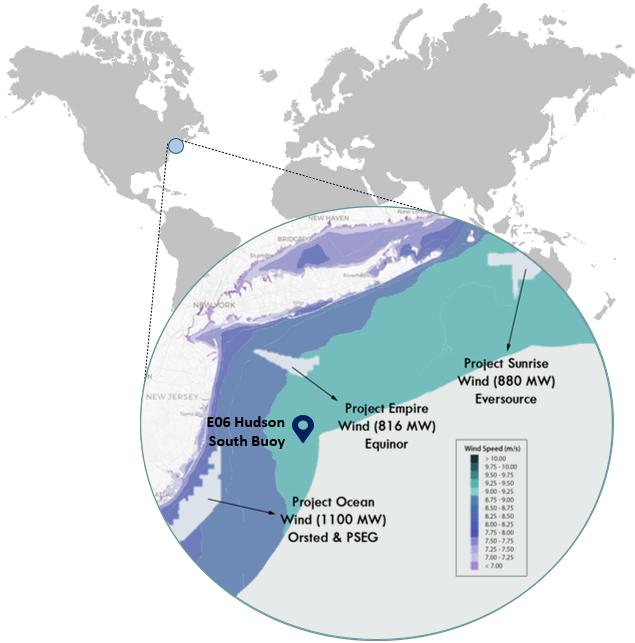

In [3]:
# Import raw wind speed and wave height data from E06 Hudson South Buoy:
wind_wave = pd.read_csv("wind_wave_data.csv", index_col=[0])
wind_wave = wind_wave[:total_days*24]
wind_speed_hourly = np.array(wind_wave["wind_speed_mps"]).reshape(-1,1)
wave_height_hourly = np.array(wind_wave["wave_height_m"]).reshape(-1,1)

# Spatial variablity for wind speed (for wave height we assume no spatial variability)
np.random.seed(24)
wind_speed_hourly_sv = np.random.normal(loc = wind_speed_hourly, scale = 1, 
                                        size = (wind_speed_hourly.shape[0],N_t))

# Aggregate hourly data into daily scale by taking the mean every 24 hours
wind_speed_daily_sv = np.array([np.mean(wind_speed_hourly_sv[24*x:24*(x+1),:],0) for x in range(total_days)])
wave_height_daily = np.array([np.mean(wave_height_hourly[24*x:24*(x+1)]) for x in range(total_days)])

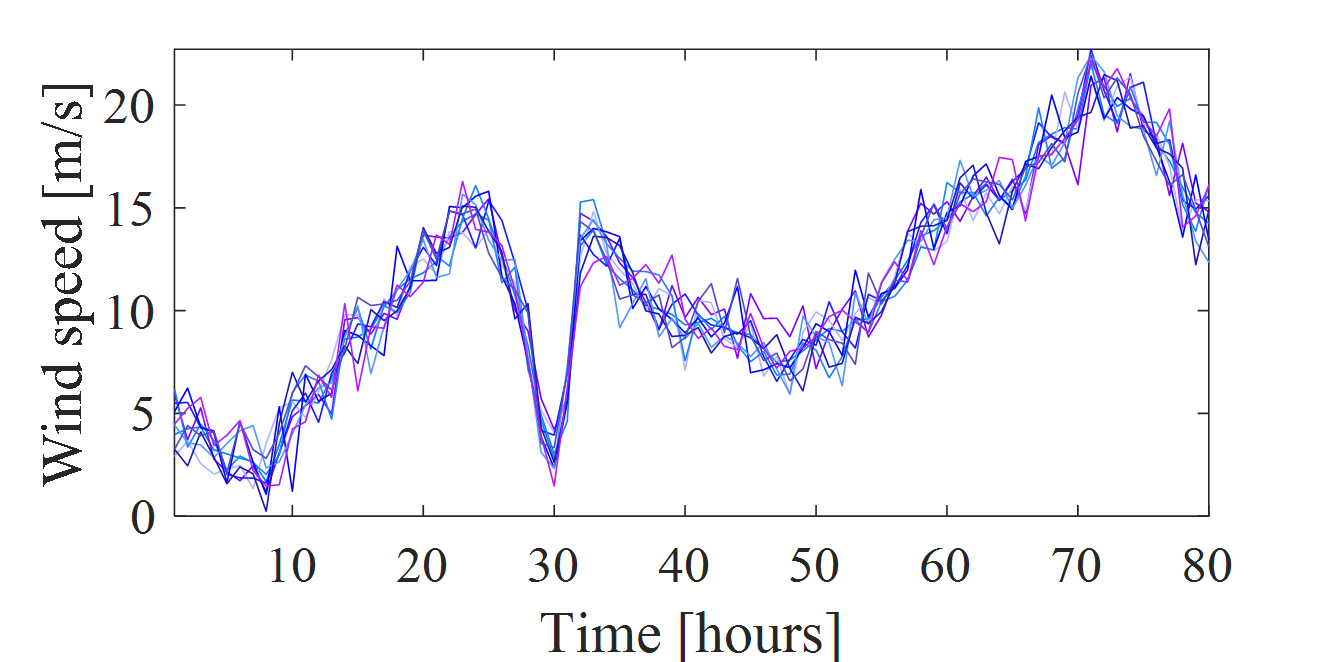

## Calculation of normalized power
<a id='sec_1_2'></a>
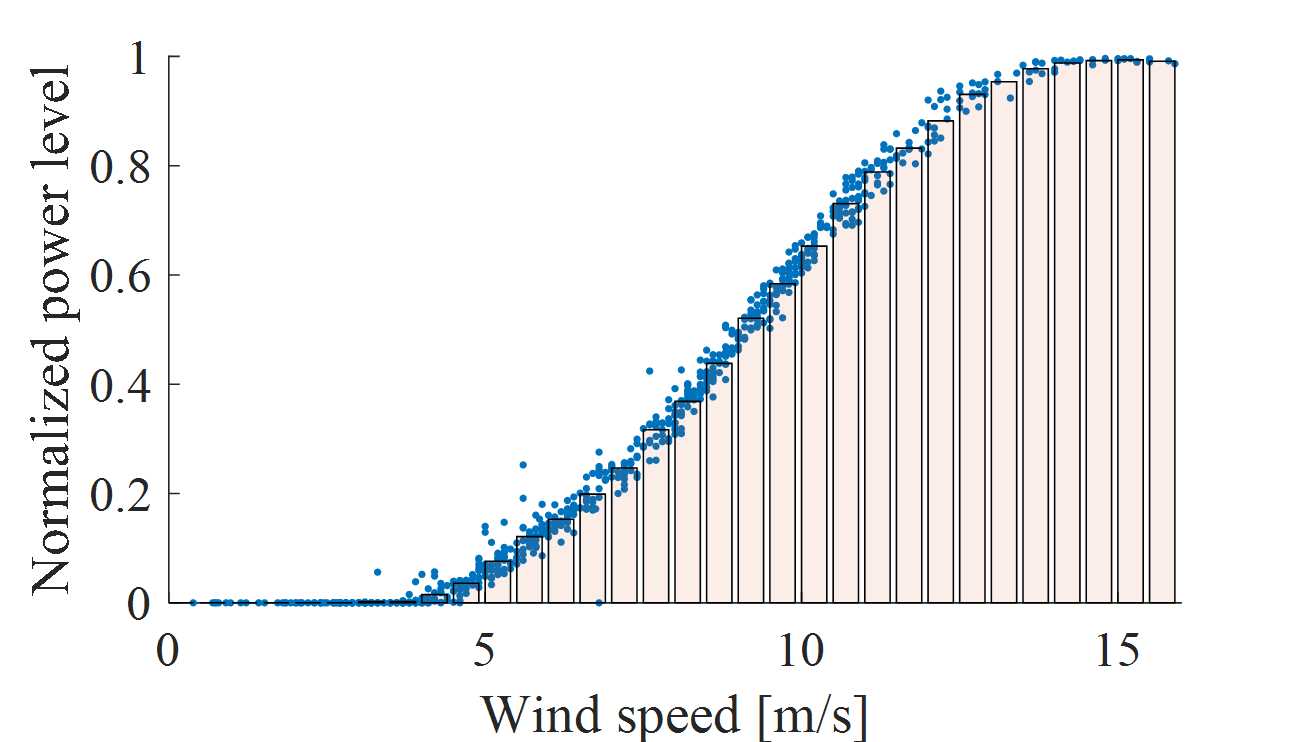

In [4]:
# Import binning method data
ws_bin_processed = pd.read_csv('method_of_bins.csv', usecols = [0,1])

# Normalized power
fw = np.zeros_like(wind_speed_hourly_sv) # for STH
fwL = np.zeros_like(wind_speed_daily_sv) # for LTH

for j in range(ws_bin_processed.index.shape[0]-1):
    index_true_STH = (wind_speed_hourly_sv>=ws_bin_processed['Wind speed bins'][j]) & (
        wind_speed_hourly_sv<ws_bin_processed['Wind speed bins'][j+1])
    fw[index_true_STH] = ws_bin_processed['Norm power'][j]
    

for j in range(total_days):
    fwL[j,:] = fw[j*24:(j+1)*24,:].mean(0)

## Electricity selling price data processing
<a id='sec_1_3'></a>

In [5]:
PJM_price_data_raw = pd.read_csv('da_hrl_lmps_ZONE2014.csv',usecols = [1,3,8,9]) # Load PJM dataset
PJM_price_data = PJM_price_data_raw[PJM_price_data_raw['pnode_name']=='JCPL'] # Choose the node that is closer to the offshore wind farm

sys_en_price_data = np.array(PJM_price_data['system_energy_price_da'])[:PJM_price_data.shape[0]//24*24] 

if add_incentive:
    sys_en_price_data += 24 # $/MWh

# if use_true_price_data is set to True, we use raw historical values
if use_true_price_data:
    market_prices = sys_en_price_data
    
# if use_true_price_data is set to False, data is artificially generated    
else:
    sys_en_price_data = sys_en_price_data.reshape(-1,24)
    sys_en_price = sys_en_price_data.mean(0)
    sys_en_price_std = sys_en_price_data.std(0)

    np.random.seed(0) #reproducible
    market_prices = np.random.normal(loc=sys_en_price, scale=sys_en_price_std, size=(total_days+1,24))
    market_prices[market_prices<10] = 10
    
    plt.figure(figsize = (10,5), dpi = 100)
    plt.plot(market_prices.mean(0), 'r-')

    plt.plot(sys_en_price)
    for i in range(1,11):
        plt.plot(sys_en_price-0.2*i*sys_en_price_std, 'k-', alpha = 1/(i**0.95+2))
        plt.plot(sys_en_price+0.2*i*sys_en_price_std, 'k-', alpha = 1/(i**0.95+2))
    plt.title('PJM system energy price')
    plt.xlabel('Hour of the day')
    plt.ylabel('Electricity price ($/MWh)')
    plt.legend(['Generated mean', 'True mean', '+- 0.2*STD'])
    
    market_prices = market_prices.reshape(-1,1)

if const_price:
    market_prices = 80*np.ones(wind_speed_hourly_sv.shape[0])
    
print("Mean selling price:  $", round(market_prices.mean(),2), "/MWh")

daily_avg_price = np.array([np.mean(market_prices[24*x:24+24*x]) for x in range(total_days)])

Mean selling price:  $ 60.84 /MWh


## Residual life estimations (RLEs) and repair times
<a id='sec_1_4'></a>

In [6]:
np.random.seed(24) # set seed for reproducibility of results
RLE = pd.Series(np.round(np.linspace(5,50,N_t)), index = I) # We use evenly-spaced RLEs. Could be manual if prefered

if const_tau:
    tau = 8*np.ones(N_t, dtype=np.int32)
else:
    tau = np.int32(np.random.normal(mean_repair_time, scale = std_repair_time, size = (N_t)))
print('Random repair times (in hours): ', tau)

Random repair times (in hours):  [11  5  6  4  4  3  9  8  2  8]


## Accessibility calculation
<a id='sec_1_5'></a>

In [7]:
# Accessibility
a_STH = np.zeros_like(wind_speed_hourly_sv)
a_LTH = np.zeros_like(wind_speed_daily_sv)
for i in range(N_t):
    for j in range(len(T)-tau[i]):
        if (np.all(wave_height_hourly[j:j+tau[i]] <= vessel_max_wave_height)) & (
            np.all(wind_speed_hourly_sv[j:j+tau[i],i] <= vessel_max_wind_speed)):
            a_STH[j,i] = 1
    
    for j in range(len(D)):
        if np.any(a_STH[24*j:24*(j+1),i] > 0.5): a_LTH[j,i] = 1

## Convert inputs to appropriate format
<a id='sec_1_6'></a>

In [8]:
# Convert all input datasets to pd.DataFrame
tau = pd.Series(tau, index = I)
Pi = pd.Series(market_prices[:wind_speed_hourly.shape[0]].reshape(-1), index = T)
Pi_daily = pd.Series(daily_avg_price, index = D)
fw = pd.DataFrame(fw, index = T, columns = I)
fwL = pd.DataFrame(fwL, index = D, columns = I)
a_STH = pd.DataFrame(a_STH, index = T, columns = I)
a_LTH = pd.DataFrame(a_LTH, index = D, columns = I)

In [9]:
# The input parameters are stored inside a tuple and fed into the function with the mathematical model
scalars = [Kappa, Fi, Psi, Omega, Q, R, W, B, C]
data = (I, T, D, scalars, RLE, tau, Pi, Pi_daily, fw, fwL, a_STH, a_LTH)
#The values of theta are calculated inside each function

### [Back to Table of Contents](#toc)

# Mathematical Model Formulation of HOST
<a id='sec_2'></a>

Below is a summary of the Mixed Integer Linear Program (MILP) developed in the paper. For a more detailed discussion of the constraints, please refer to the manuscript (https://arxiv.org/abs/2012.00213).

1. Objective function
\begin{equation}\label{eq1}
    \max \hspace{0.25cm} \bigg\{s + \sum_{d\in \mathcal{D}} l_d\bigg\}
\end{equation}
2. STH profit
\begin{equation}\label{eq:eq2}
    s=\hspace{-0.45cm}\sum_{i \in \mathcal{I} , t \in \mathcal{T}}\hspace{-0.3cm}[\Pi_t \cdot p_{t,i} - \mbox{K} \cdot m_{t,i} - \Phi \cdot n_{t,i} - \Psi \cdot x_{t,i}] {- \Omega \cdot v - \mbox{Q} \cdot q}
\end{equation}
3. LTH Profit
\begin{equation} \label{eq:eq3}
 l_d = \sum_{i \in \mathcal{I}} \bigg[\Pi_d \cdot p_{d,i}^L - \mbox{K} \cdot m_{d,i}^L - \Phi \cdot n_{d,i}^L - {\Psi\cdot\tau_i (m_{d,i}^L+n_{d,i}^L)\bigg] - \Omega \cdot v_d^L \quad \forall d \in \mathcal{D}}
\end{equation}
4. Force maintenance tasks
\begin{equation} \label{eq:maint}
\sum_{t \in \mathcal{T}}(m_{t,i}+n_{t,i})+\sum_{d \in \mathcal{D}}(m_{d,i}^L+n_{d,i}^L) \geq \theta_i \quad \forall  i \in \mathcal{I}
\end{equation}
5. Consecutive hours of maintenance
\begin{equation} \label{eq:crew}
\sum_{\tilde{t}=t}^{t+\tau_i -1} x_{\tilde{t},i} \geq \tau_i \cdot (m_{t,i}+n_{t,i}) \quad \forall t \in \mathcal{T}, i \in \mathcal{I}
\end{equation}
6. Max number of crews
\begin{equation} \label{eq:crew2}
\sum_{i \in \mathcal{I}} x_{t,i} \leq \mbox{B} \quad \forall t \in \mathcal{T}
\end{equation}
7. STH Preventive maintenance before RLE
\begin{equation} \label{eq:dead1}
m_{t,i} \leq \frac{24 \cdot \lambda_i}{t} \quad \forall t \in \mathcal{T}, i \in \mathcal{I}
\end{equation}
8. LTH Preventive maintenance before RLE
\begin{equation}\label{eq:dead2}
    m_{d,i}^L \leq \frac{ \lambda_i}{d} \quad \forall d \in \mathcal{D}, i \in \mathcal{I}
\end{equation}
9. STH Corrective maintenance after RLE
\begin{equation}\label{eq:dead3}
    n_{t,i} \leq \frac{t}{24 \cdot \lambda_i + \beta} \quad \forall t \in \mathcal{T}, i \in \mathcal{I}
\end{equation}
10. LTH Corrective maintenance after RLE
\begin{equation}\label{eq:dead4}
n_{d,i}^L \leq \frac{d_J - \lambda_i}{d_J -d+ \beta}  \quad \forall d \in \mathcal{D}, i \in \mathcal{I},
\end{equation}
11. STH Turbine availability
\begin{equation} \label{eq:availability}
y_{t,i} \leq \left( \frac{24 \cdot \lambda_i}{t} \right)^{\mbox{M}}+ \frac{24 \cdot \sum_{t \in \mathcal{T}}n_{t,i}- \sum_{t \in \mathcal{T}}(t \cdot n_{t,i})}{t_F-t+\beta}+{1-\theta_i,
\quad \forall t \in \mathcal{T}, i \in \mathcal{I}} 
\end{equation}
12. LTH Turbine availability
\begin{equation} \label{eq:availability2}
y_{d,i}^L \leq \left( \frac{ \lambda_i}{d} \right)^{\mbox{M}}\hspace{-0.05cm}+\frac{d_J- \sum_{d \in \mathcal{D}}(d \cdot n_{d,i}^L)}{d_J-d+\beta} \hspace{0.3cm} {\forall d \in \mathcal{D}, i \in \mathcal{I}} 
\end{equation}
13. Maintenance-incured unavailability
\begin{equation} \label{eq:maintt}
   y_{t,i} \leq 1 - x_{t,i} \quad \forall t \in \mathcal{T}, i \in \mathcal{I}
\end{equation}
14. STH Vessel rental
\begin{equation} \label{eq:vessel1}
    v \geq m_{t,i}+n_{t,i} \quad \forall t \in \mathcal{T}, i \in \mathcal{I}
\end{equation}
15. LTH Vessel rental
\begin{equation}\label{eq:vessel2}
  v_d^L \geq m_{d,i}^L+n_{d,i}^L \quad \forall d \in \mathcal{D}, i \in \mathcal{I}  
\end{equation}
16. STH Total workhours (Overtime)
\begin{equation} \label{eq:workhours}
\sum_{t \in \mathcal{T}, i \in \mathcal{I}} x_{t,i} \leq \mbox{B} \cdot \mbox{W}+q
\end{equation}
17. LTH Total workhours
\begin{equation} \label{eq:workhours2}
\sum_{i \in \mathcal{I}} (m_{d,i}^L+n_{d,i}^L) \cdot \tau_i \leq \mbox{B} \cdot \mbox{W} \quad \forall d \in \mathcal{D}
\end{equation}
18. STH Power output
\begin{equation}\label{eq:eqnom}
    p_{t,i}=\mbox{R} \cdot f_{t,i} \cdot y_{t,i} \quad \forall t \in \mathcal{T}, i \in \mathcal{I}
\end{equation}
19. LTH Power output
\begin{equation} \label{eq:nom2}
p_{d,i}^L=24 \cdot \mbox{R} \cdot f_{d,i}^L \cdot \left(y_{d,i}^L- m_{d,i}^L \cdot \frac{\tau_i}{24} \right) \quad \forall d \in \mathcal{D}, i \in \mathcal{I}
\end{equation}
20. Curtailment
\begin{equation} \label{eq:curtailment}
\sum_{i \in \mathcal{I}} p_{t,i} \leq \sum_{i \in \mathcal{I}} \cdot f_{t,i} \cdot \mbox{R} \cdot \mbox{C}_t \quad \forall t \in \mathcal{T}
\end{equation}
21. STH Accessibility
\begin{equation} \label{eq:access1}
    m_{t,i}+n_{t,i} \leq \alpha_{t,i} \quad \forall t \in \mathcal{T}, i \in \mathcal{I}
\end{equation}
22. LTH Accessibility
\begin{equation} \label{eq:access2}
    m_{d,i}^L+n_{d,i}^L \leq \alpha_{d,i}^L \quad \forall d \in \mathcal{D}, i \in \mathcal{I}
\end{equation}

In [25]:
############################ Model Generation #################################
def owf_HOST(Din, data, N_t=10, opt_horizon=60, verbose=False, unexpected=False, full_horizon=True, manual_theta=None):
    """
    A function containing the formulation of HOST.
    
    Inputs::
    
    - Din: -Integer- A scalar with the day of the dataset that will be considered as the 
    initial day in the optimization
    
    - data: A tuple with the inputs of the optimization program. The order of the inputs 
    is as follows:
    0:I, 1:T, 2:D, 3:scalars, 4:rle, 5:tau, 6:Pi, 7:Pi_daily, 8:fw, 9:fwL, 10:a_STH, 
    11:a_LTH, where the order of the scalar parameters is as follows:
    0:Kappa, 1:Fi, 2:Psi, 3:Omega, 4:Q, 5:R, 6:W, 7:B, 8:C
  
    - N_t: -Integer- Number of wind turbines to consider (must be less than or equal to 
    the number of wind turbines used to process the data)
        
    - opt_horizon: -Integer- Define the optimization horizon in days (default=60)
    
    - verbose: -Boolean- Print key parameter and variable values in each iteration; 
    mainly used for debugging (default=False)
        
    - unexpected: -Boolean- Introduces unexpected failures in the case study for wind 
    turbines 1 and 3 at days 17 and 36, respectively (default=False)
    
    - full_horizon: -Boolean- If the program should run through the full optimization 
    horizon (default=True)
    
    - manual_theta: -Pandas Series of Integers- A Pandas Series of shape (N_t,) with the 
    manual values of theta (default=None)
    
    
    Outputs::
    
    - hourly_schedule: A tuple whose elements are the following DataFrames (pm_hourly_df, 
    cm_hourly_df, x_hourly, avail_hourly, power_hourly)
    
    - metrics: A Pandas Series with the following metrics: [total_profit, total_cost, 
    vessel_rentals, rentals_utilized, total_downtime, total_prod_loss, total_PM, total_CM, 
    opt_time]
    """
    I = data[0]
    T = data[1]
    D = data[2]
    
    scalars = data[3]
    Kappa = scalars[0]      #($/PM task) Cost of each PM task
    Fi = scalars[1]        #($/CM task) Cost of each CM task
    Psi = scalars[2]         #($/hour) Maintenance crew hourly cost
    Omega = scalars[3]     #($/day) Vessel daily rental cost
    Q = scalars[4]           #($/hour) Maintenance crew overtime cost
    R = scalars[5]            #(MW) Wind turbine rated power output
    W = scalars[6]             #(hours) Number of workhours with standard payment
    B = scalars[7]             #(-) Number of maintenance crews
    C = scalars[8]
    
    rle = data[4].copy(True)
    tau = data[5]
    Pi = data[6]
    Pi_daily = data[7]
    fw = data[8]
    fwL = data[9]
    a_STH = data[10]
    a_LTH = data[11]

    # Some metrics that will be updated in each iteration
    pm_hourly_df = pd.DataFrame(columns = I) #hourly preventive maintenance task schedule
    cm_hourly_df = pd.DataFrame(columns = I) #hourly corrective maintenance task schedule
    x_hourly = pd.DataFrame(columns = I)     #hourly occupacy of maintenance crew in each wind turbine
    avail_hourly = pd.DataFrame(columns = I) #hourly turbine availability
    power_hourly = pd.DataFrame(columns = I) #Hourly power output by each turbine
    
    
    total_profit = 0
    total_cost = 0
    v1 = [] # vessel rental for day Din+1 (auxilliary parameter for calculations)
    vessel_rentals = 0
    rentals_utilized = 0
    total_downtime = 0
    total_prod_loss = 0
    
    if rle is None:
        rle = pd.Series(np.round(np.linspace(5,opt_horizon-10,N_t)), index = I) # We use evenly-spaced RLEs
    if manual_theta is None:
        theta = pd.Series(np.zeros(len(I)), index = I)
        theta[rle <= 30] = 1 #we set theta to one only for wind turbines with RLE<30 days
    else: 
        theta = manual_theta

    owf = gp.Model('Offshore Windfarm Maintenance Scheduling')
    
    opt_hor = opt_horizon #set optimization horizon (days)
    
    t1 = time()
    
    run = -1 #do not change
    
    # The horizon will keep rolling until all wind turbines have been visited
    while (any(np.sum(x_hourly,0) < 1)) or ((unexpected) and ((run < 36) or (any(theta > 0)))):
        
        run += 1
        
        if verbose:
            print('*********************')
            print(f'Run number = {run}')
            print(f'theta = {theta}')
            print(f'rle = {rle}')
            print('*********************')
        
        i = I
        t = T[(Din+run)*24:(Din+run+1)*24] # Hours in a day (STH)
        if (run + 10 < opt_hor) | (N_t >= 50):
            d = D[Din+run+1:Din+opt_hor] # Days considered in optimization (LTH)
            
        else:
            d = D[Din+run+1:Din+run+11] #to completely avoid infeasible solutions 
            #we should look at which turbines still need repair, find the one that 
            #has the most inaccessible days and use this number of days as an extension of the LTH
            
            
        
        owf.update()
        
        # Continuous variables
        P = owf.addVars(t, i, lb=0, name="P") # Hourly power generation for the STH
        PL = owf.addVars(d, i, lb=0, name="PL") # Daily power generation for the LTH
        s = owf.addVar(name = "s") #Profit obtained in the STH
        l = owf.addVars(d, name = "l") #Profit obtained in day d of the LTH

        # Integer variable
        q = owf.addVar(lb = 0, vtype = gp.GRB.INTEGER, name = "q") # Overtime hours

        # Binary Variables
        m = owf.addVars(t, i, vtype = gp.GRB.BINARY, name = "m") #Preventive maintenance is scheduled at hour t, wt i in the STH
        mL = owf.addVars(d, i, vtype = gp.GRB.BINARY, name = "mL") #Preventive maintenance is scheduled at day d, wt i in the LTH
        n = owf.addVars(t, i, vtype = gp.GRB.BINARY, name = "n") #Corrective maintenance is scheduled at hour t, wt i in the STH
        nL = owf.addVars(d, i, vtype = gp.GRB.BINARY, name = "nL") #Corrective maintenance is scheduled at day d, wt i in the LTH
        y = owf.addVars(t, i, vtype = gp.GRB.BINARY, name = "y") #Turbine availability at hour t, wt i in the STH
        yL = owf.addVars(d, i, vtype = gp.GRB.BINARY, name = "yL") #Turbine availability at day d, wt i in the LTH
        v = owf.addVar(vtype = gp.GRB.BINARY, name = "v") #Vessel is rented in the STH
        vL = owf.addVars(d, vtype = gp.GRB.BINARY, name = "vL") #Vessel is rented at day d in the LTH
        x = owf.addVars(t, i, vtype = gp.GRB.BINARY, name = "x") #Turbine is under maintenance at hour t, wt i in the STH

        owf.update()
        
        availability_1st_term_STH = np.ones((24,N_t))
        availability_1st_term_STH[24*np.array(rle)/np.arange(1,25).reshape((-1,1)) <= 0] = 0.
        availability_1st_term_STH = pd.DataFrame(availability_1st_term_STH, columns=i, index=t)
        
        availability_1st_term_LTH = np.ones((len(d),N_t))
        availability_1st_term_LTH[np.array(rle)-1-np.arange(len(d)).reshape((-1,1)) <= 0] = 0.
        availability_1st_term_LTH = pd.DataFrame(availability_1st_term_LTH, columns=i, index=d)

        # Constraints
        obj_fun = s + gp.quicksum(l[day] for day in d) #objective function
        con1 = owf.addConstr(s == gp.quicksum(Pi[hour]*P[hour,wt]-Kappa*m[hour,wt]-Fi*n[hour,wt]
                                         -Psi*x[hour,wt] for hour in t for wt in i)-Omega*v-Q*q
                            , name = "STH profit")
        con2 = owf.addConstrs((l[day] == gp.quicksum(Pi_daily[day]*PL[day,wt]-Kappa*mL[day,wt]-Fi*nL[day,wt]
                                                     -Psi*tau[wt]*(mL[day,wt]+nL[day,wt]) for wt in i) 
                               -Omega*vL[day] for day in d), name = "LTH profit")
        con3 = owf.addConstrs((gp.quicksum(m[hour,wt]+n[hour,wt] for hour in t)+
                              gp.quicksum(mL[day,wt]+nL[day,wt] for day in d) >= 
                              theta[wt] for wt in i), name = "Force maintenance")
        con4 = owf.addConstrs((gp.quicksum(x[t[t.index(hour)+t_hat],wt] for t_hat in range(tau[wt]))
                              >= tau[wt]*(m[hour,wt]+n[hour,wt]) for hour in t for wt in i 
                              if t.index(hour) <= len(t)-tau[wt]), name = "Consecutive")
        con5 = owf.addConstrs((gp.quicksum(x[hour,wt] for wt in i) <= B for hour in t), 
                             name = 'Max tasks per hour')
        con6 = owf.addConstrs((m[hour,wt]<=24*rle[wt]/(t.index(hour)+1) for hour in t for wt in i),
                              name = 'STH PM RLE')
        con7 = owf.addConstrs((mL[day,wt]<=rle[wt]/(d.index(day)+2) for day in d for wt in i),
                              name = 'LTH PM RLE')
        con8 = owf.addConstrs((n[hour,wt]<=(t.index(hour)+1)/(24*rle[wt]+0.1) for hour in t for wt in i),
                              name = 'STH CM RLE')
        con9 = owf.addConstrs((nL[day,wt]<=(d.index(d[-1])+1-rle[wt])/
                               (d.index(d[-1])-d.index(day)+0.1) for day in d for wt in i),
                              name = 'LTH CM RLE')
        con10 = owf.addConstrs((y[hour,wt] <= availability_1st_term_STH[wt][hour]
                               + gp.quicksum((23-t.index(tt))*n[tt,wt] for tt in t)/
                                 (23-t.index(hour)+0.1) + 1.0-theta[wt]
                                 for hour in t for wt in i), name = 'Availability STH')
        con11 = owf.addConstrs((yL[day,wt] <= availability_1st_term_LTH[wt][day]
                                +(d.index(d[-1])-gp.quicksum(d.index(dd)*nL[dd,wt] for dd in d))/
                                (d.index(d[-1])-d.index(day)+0.1) for day in d for wt in i),
                                name = "Availability LTH")
        con12 = owf.addConstrs((y[hour,wt] <= 1 - x[hour,wt] for hour in t for wt in i),
                               name = "Unavailability from maintenance")
        con13 = owf.addConstr((v>=1/N_t*gp.quicksum(m[hour,wt]+n[hour,wt] for hour in t for wt in i))
                             , name = "STH vessel")
        con14 = owf.addConstrs((vL[day] >= 1/N_t*gp.quicksum(mL[day,wt]+nL[day,wt] for wt in i)
                             for day in d), name = "LTH vessel")
        con15 = owf.addConstr((gp.quicksum(x[hour,wt] for hour in t for wt in i)<=B*W+q),
                             name = "Overtime")
        con16 = owf.addConstrs((gp.quicksum((mL[day,wt]+nL[day,wt])*tau[wt] for wt in i) <= B*W 
                               for day in d), name = 'Max daily repairs')
        con17 = owf.addConstrs((P[hour,wt]<=R*(fw[wt][hour]+1e-4)*y[hour,wt] for hour in t for wt in i),
                              name = "STH power")
        con18 = owf.addConstrs((PL[day,wt]<=24*R*(fwL[wt][day]+1e-4)*(yL[day,wt]-mL[day,wt]*tau[wt]/24) 
                                for day in d for wt in i),name = "LTH power")
        con19 = owf.addConstrs((m[hour,wt]+n[hour,wt]<=a_STH[wt][hour] for hour in t for wt in i),
                              name = "STH access")
        con20 = owf.addConstrs((mL[day,wt]+nL[day,wt]<=a_LTH[wt][day] for day in d for wt in i),
                              name = "LTH access")
        con21 = owf.addConstrs((m[hour,wt]+n[hour,wt]<=0 for wt in i for hour in t 
                                if t.index(hour) < 5 or t.index(hour) > 20-tau[wt]))
        curtail = owf.addConstrs(gp.quicksum(P[hour,wt] for wt in i) <= 
                                 gp.quicksum(fw[wt][hour] for wt in i)*R*C for hour in t)
        

        
        # Set objective
        owf.setObjective(obj_fun, gp.GRB.MAXIMIZE)

        owf.update()
        
        # Solve model
        owf.optimize()
        
        if verbose:
            print(f'\n ***** Results for run {run} ****')

            print('\n ** STH max revenue **')
            print(pd.DataFrame(R*(np.array(fw)[(Din+run)*24:(Din+run+1)*24,:]+1e-4)*
                               np.array(Pi)[(Din+run)*24:(Din+run+1)*24].reshape(-1,1), index=t, columns=i))

            print('\n ** STH max revenue sum over hours **')
            print(pd.DataFrame(R*(np.array(fw)[(Din+run)*24:(Din+run+1)*24,:]+1e-4)*
                               np.array(Pi)[(Din+run)*24:(Din+run+1)*24].reshape(-1,1), index=t, columns=i).sum(0))

            print('\n ** STH accessibility **')
            print(pd.DataFrame(np.array(a_STH)[(Din+run)*24:(Din+run+1)*24,:], index=t, columns=i) )

            print('\n ** STH maintenance plan **')
            print(pd.DataFrame(np.array(owf.getAttr('X',m).values()).reshape(-1,len(i)), columns = i, index = t)+
                 2*pd.DataFrame(np.array(owf.getAttr('X',n).values()).reshape(-1,len(i)), columns = i, index = t))

            print('\n ** LTH max revenue **')
            print(pd.DataFrame(24*R*(np.array(fwL)[Din+run+1:Din+opt_hor,:]+1e-4)*
                               np.array(Pi_daily)[Din+run+1:Din+opt_hor].reshape(-1,1), index=d, columns=i))

            print('\n ** LTH maintenance plan **')
            print(pd.DataFrame(np.array(owf.getAttr('X',mL).values()).reshape(-1,len(i)), columns = i, index = d)+
                 2*pd.DataFrame(np.array(owf.getAttr('X',nL).values()).reshape(-1,len(i)), columns = i, index = d))


            print('\n ** LTH accessibility **')
            print(pd.DataFrame(np.array(a_LTH)[Din+run+1:Din+opt_hor,:], index=d, columns=i) )

        
        
        if owf.SolCount == 0:
            empty_df = pd.DataFrame(np.zeros((1,len(i))), columns = i, index = [t[0]])
            pm_hourly_df = pd.concat([pm_hourly_df,empty_df])
            cm_hourly_df = pd.concat([cm_hourly_df,empty_df])
            x_hourly = pd.concat([x_hourly,empty_df])
            avail_hourly = pd.concat([avail_hourly,empty_df])
            power_hourly = pd.concat([power_hourly,empty_df])
            break
        
        mm = pd.DataFrame(np.array(owf.getAttr('X',m).values()).reshape(-1,len(i)), columns = i, index = t)
        nn = pd.DataFrame(np.array(owf.getAttr('X',n).values()).reshape(-1,len(i)), columns = i, index = t)
        xx = pd.DataFrame(np.array(owf.getAttr('X',x).values()).reshape(-1,len(i)), columns = i, index = t)
        yy = pd.DataFrame(np.array(owf.getAttr('X',y).values()).reshape(-1,len(i)), columns = i, index = t)
        PP = pd.DataFrame(np.array(owf.getAttr('X',P).values()).reshape(-1,len(i)), columns = i, index = t)

        pm_hourly_df = pd.concat([pm_hourly_df,mm])
        cm_hourly_df = pd.concat([cm_hourly_df,nn])
        x_hourly = pd.concat([x_hourly,xx])
        avail_hourly = pd.concat([avail_hourly,yy])
        power_hourly = pd.concat([power_hourly,PP])
        
        rle -= 1
        rle[rle<0] = 0
        
        for wt in i:
            if rle[wt] == 30: theta[wt] = 1
            if (np.any(mm[wt]+nn[wt] >= 0.5)): theta[wt] = 0
        
        if unexpected and (run == 17): theta['WT1'] = 1
        if unexpected and (run == 36): theta['WT3'] = 1
    
        
        total_profit += s.X
        total_cost += np.sum(np.array(fw[(Din+run)*24:(Din+run+1)*24][i])*np.array(
            Pi[(Din+run)*24:(Din+run+1)*24]).reshape(-1,1)*R*C) - s.X
        
        
        if run == 0: 
            v1.append(round(owf.getAttr("X",vL).values()[0]))
            vessel_rentals += v.X + owf.getAttr("X",vL).values()[0]
            rentals_utilized += v.X
        elif run < opt_hor-1:
            v1.append(round(owf.getAttr("X",vL).values()[0]))
            rentals_utilized += v.X
            vessel_rentals += owf.getAttr("X",vL).values()[0] + (1-v1[run-1])*v.X # the second term is saying: if
                                                                                  # the maintenance was not scheduled in 
                                                                                  # LTH of the previous horizon, include 
                                                                                  # current vessel 
        
        total_downtime += 24*N_t - np.sum(owf.getAttr("X",y).values())
        total_prod_loss += np.sum(np.array(fw[(Din+run)*24:(Din+run+1)*24])*R*C) - np.sum(np.array(PP))
        
        #if verbose and run == 6: break
        
    opt_time = round(time()-t1,2)
    print(f'Optimization finished. Total time: {opt_time} sec')
    
    # Add the cost of the unutilized vessels:
    total_cost += (vessel_rentals-rentals_utilized)*Omega
    
    hourly_schedule = (pm_hourly_df, cm_hourly_df, x_hourly, avail_hourly, power_hourly)
    total_PM = round(np.sum(np.array(pm_hourly_df)))
    total_CM = round(np.sum(np.array(cm_hourly_df)))
    metrics = pd.Series([total_profit, total_cost, vessel_rentals, rentals_utilized, total_downtime, 
               total_prod_loss, total_PM, total_CM, opt_time], index=['total_profit_$', 'total_cost_$', 'vessel_rentals', 
                                                                      'rentals_utilized', 'total_downtime_hours', 
                                                                      'total_prod_loss_MWh', 'total_PM', 'total_CM', 
                                                                      'opt_time_sec'])
        
    return hourly_schedule, metrics

In [26]:
hourly_schedule, metrics = owf_HOST(Din=0, data=data, N_t=N_t)
HOST_sols = {'Hourly schedules':hourly_schedule, 'Metrics':metrics} #make a dictionary with both the schedules and the metrics

Using license file C:\Users\user\gurobi.lic
Academic license - for non-commercial use only - expires 2021-09-27
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 4958 rows, 3681 columns and 56476 nonzeros
Model fingerprint: 0xc3b0c876
Variable types: 890 continuous, 2791 integer (2790 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-04, 1e+03]
Presolve removed 4304 rows and 2737 columns
Presolve time: 0.16s
Presolved: 654 rows, 944 columns, 10774 nonzeros
Variable types: 145 continuous, 799 integer (752 binary)
Found heuristic solution: objective 3139335.4097
Found heuristic solution: objective 3874060.5230

Root relaxation: objective 5.732868e+06, 245 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth In

Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-04, 1e+03]

MIP start from previous solve produced solution with objective 5.56268e+06 (0.13s)
Loaded MIP start from previous solve with objective 5.56268e+06

Presolve removed 14272 rows and 10252 columns
Presolve time: 0.26s
Presolved: 443 rows, 665 columns, 5112 nonzeros
Variable types: 94 continuous, 571 integer (524 binary)

Explored 0 nodes (0 simplex iterations) in 0.40 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 5.56268e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.562678665706e+06, best bound 5.562678665706e+06, gap 0.0000%
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 19514 rows, 14472 columns and 217986 nonzeros
Model fingerprint: 0x9e06ee58
Variable types: 3494 continuous,


Explored 0 nodes (0 simplex iterations) in 0.53 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 4.96516e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.965157567705e+06, best bound 4.965157567705e+06, gap 0.0000%
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 51623 rows, 38181 columns and 551221 nonzeros
Model fingerprint: 0x48447fec
Variable types: 9185 continuous, 28996 integer (28985 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-04, 1e+03]

MIP start from previous solve produced solution with objective 4.80137e+06 (0.17s)
Loaded MIP start from previous solve with objective 4.80137e+06

Presolve removed 51180 rows and 37516 columns
Presolve time: 0.39s
Presolved: 443 rows, 665 columns, 5112 nonzeros
Variable types: 94 continu

Loaded MIP start from previous solve with objective 4.34924e+06

Presolve removed 80692 rows and 59167 columns
Presolve time: 0.44s
Presolved: 443 rows, 665 columns, 5112 nonzeros
Variable types: 94 continuous, 571 integer (524 binary)

Explored 0 nodes (0 simplex iterations) in 0.77 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 4.34924e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.349236303874e+06, best bound 4.349236303874e+06, gap 0.0000%
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 85139 rows, 62757 columns and 864481 nonzeros
Model fingerprint: 0xc84eb59f
Variable types: 15029 continuous, 47728 integer (47709 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-04, 1e+03]

MIP start from previous solve produced solution with

In [12]:
print(HOST_sols['Metrics']) #print the metrics (example)

total_profit_$          1.812225e+06
total_cost_$            7.014373e+04
vessel_rentals          5.000000e+00
rentals_utilized        5.000000e+00
total_downtime_hours    1.490000e+02
total_prod_loss_MWh     2.991901e+01
total_PM                1.000000e+01
total_CM                0.000000e+00
opt_time_sec            2.610000e+01
dtype: float64


In [12]:
# Save the raw solutions into a .json file
HOST_file = open("HOST_solutions_example.json", "wb") #open("filename.json", mode ("wb" = write mode))
pickle.dump(HOST_sols,HOST_file)
HOST_file.close()

### [Back to Table of Contents](#toc)

# Benchmarks
<a id='sec_3'></a>

The following benchmark adaptations of **HOST** where used in the study:
        
1. *Corrective Maintenance Strategy (**CMS**)*: Maintenance actions are only scheduled reactively (i.e. post-failure).
        
2. *Time-Based Strategy (**TBS**)*: Maintenance actions are scheduled, whenever feasible, right before the turbines fail. 
    
3. *Production-Based Opportunistic Strategy (**PBOS**)*: A special case of HOST wherein production-based opportunities are prioritized, but not dispatch- or access-based opportunities. 
    
4. *Besnard et al. (2009), Opportunistic Strategy (**BESN**)*: This is akin to the opportunistic framework proposed in [Besnard et al. (2009)](https://ieeexplore.ieee.org/abstract/document/5281868) which accounts for dispatch- and production-based opportunities, but not access-based opportunities. We adapted our own version of this strategy using the formulation in Section II-B. 

In [27]:
import benchmarks #benchmarks saved in an external python file stored in the same folder

In [28]:
PBOS_sched, PBOS_metrics = benchmarks.PBOS(Din=0, data=data)

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 3538 rows, 3681 columns and 54466 nonzeros
Model fingerprint: 0x3c60f565
Variable types: 890 continuous, 2791 integer (2790 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-02, 1e+03]
Presolve removed 2682 rows and 2361 columns
Presolve time: 0.16s
Presolved: 856 rows, 1320 columns, 23106 nonzeros
Variable types: 173 continuous, 1147 integer (1060 binary)
Found heuristic solution: objective 2339310.0733
Found heuristic solution: objective 2355705.5465

Root relaxation: objective 5.733656e+06, 417 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5733656.20    0   91 2355705.55 5733656.20   14

Optimize a model with 20733 rows, 21456 columns and 307651 nonzeros
Model fingerprint: 0xbda89aa6
Variable types: 5175 continuous, 16281 integer (16275 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-02, 1e+03]

MIP start from previous solve produced solution with objective 5.2619e+06 (0.23s)
MIP start from previous solve produced solution with objective 5.26557e+06 (0.24s)
MIP start from previous solve produced solution with objective 5.27042e+06 (0.24s)
MIP start from previous solve produced solution with objective 5.27168e+06 (0.27s)
MIP start from previous solve produced solution with objective 5.27233e+06 (0.27s)
MIP start from previous solve produced solution with objective 5.27241e+06 (0.28s)
Loaded MIP start from previous solve with objective 5.27241e+06

Presolve removed 19979 rows and 20330 columns
Presolve time: 0.66s
Presolved: 754 rows, 1126 columns, 20602 nonzeros



Presolve removed 39574 rows and 40274 columns
Presolve time: 1.05s
Presolved: 704 rows, 1126 columns, 18745 nonzeros
Variable types: 103 continuous, 1023 integer (936 binary)

Explored 0 nodes (0 simplex iterations) in 1.44 seconds
Thread count was 4 (of 4 available processors)

Solution count 8: 4.73411e+06 4.73321e+06 4.73265e+06 ... 4.71051e+06

Optimal solution found (tolerance 1.00e-04)
Best objective 4.734107675753e+06, best bound 4.734107675753e+06, gap 0.0000%
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 43420 rows, 44577 columns and 612144 nonzeros
Model fingerprint: 0xe8f21943
Variable types: 10712 continuous, 33865 integer (33852 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-02, 1e+03]

MIP start from previous solve produced solution with objective 4.6839e+06

Loaded MIP start from previous solve with objective 4.2282e+06

Presolve removed 63772 rows and 64513 columns
Presolve time: 0.79s
Presolved: 718 rows, 1127 columns, 19441 nonzeros
Variable types: 103 continuous, 1024 integer (937 binary)

Explored 0 nodes (0 simplex iterations) in 1.04 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 4.2282e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.228196918912e+06, best bound 4.228196918912e+06, gap 0.0000%
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 67368 rows, 68481 columns and 896756 nonzeros
Model fingerprint: 0x59256e45
Variable types: 16380 continuous, 52101 integer (52080 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-02, 1e+03]

MIP start from previous solve produced solution wi

In [29]:
BESN_sched, BESN_metrics = benchmarks.BESN(Din=0, data=data)

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 3538 rows, 3681 columns and 54466 nonzeros
Model fingerprint: 0xa59412a5
Variable types: 890 continuous, 2791 integer (2790 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-02, 1e+03]
Presolve removed 2683 rows and 2365 columns
Presolve time: 0.18s
Presolved: 855 rows, 1316 columns, 23285 nonzeros
Variable types: 172 continuous, 1144 integer (1058 binary)
Found heuristic solution: objective 2328949.8471
Found heuristic solution: objective 2342401.3653

Root relaxation: objective 5.732156e+06, 388 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5732156.26    0   91 2342401.37 5732156.26   14

Thread count was 4 (of 4 available processors)

Solution count 1: 5.56268e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.562678665706e+06, best bound 5.562678665706e+06, gap 0.0000%
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 13954 rows, 14472 columns and 210126 nonzeros
Model fingerprint: 0x712fe1fd
Variable types: 3494 continuous, 10978 integer (10974 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-02, 1e+03]

MIP start from previous solve produced solution with objective 5.40388e+06 (0.15s)
Loaded MIP start from previous solve with objective 5.40388e+06

Presolve removed 13188 rows and 13348 columns
Presolve time: 0.41s
Presolved: 766 rows, 1124 columns, 21084 nonzeros
Variable types: 103 continuous, 1021 integer (935 binary)

Explored 0 nodes (0 si

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 37103 rows, 38181 columns and 530761 nonzeros
Model fingerprint: 0x422ee45f
Variable types: 9185 continuous, 28996 integer (28985 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-02, 1e+03]

MIP start from previous solve produced solution with objective 4.80137e+06 (0.28s)
Loaded MIP start from previous solve with objective 4.80137e+06

Presolve removed 36399 rows and 37058 columns
Presolve time: 0.84s
Presolved: 704 rows, 1123 columns, 18955 nonzeros
Variable types: 103 continuous, 1020 integer (934 binary)

Explored 0 nodes (0 simplex iterations) in 1.17 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 4.80137e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.801373925257e+06, best boun


MIP start from previous solve produced solution with objective 4.34908e+06 (0.26s)
MIP start from previous solve produced solution with objective 4.34924e+06 (0.26s)
Loaded MIP start from previous solve with objective 4.34924e+06

Presolve removed 57917 rows and 58708 columns
Presolve time: 0.73s
Presolved: 718 rows, 1124 columns, 19441 nonzeros
Variable types: 103 continuous, 1021 integer (935 binary)

Explored 0 nodes (0 simplex iterations) in 1.05 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 4.34924e+06 4.34908e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.349236303874e+06, best bound 4.349236303874e+06, gap 0.0000%
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 61579 rows, 62757 columns and 831421 nonzeros
Model fingerprint: 0xf9eb2bbe
Variable types: 15029 continuous, 47728 integer (47709 binary)
Coefficient statistics:
  Matr

In [31]:
TBS_sched, TBS_metrics = benchmarks.TBS(Din=0, data=data)

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 4138 rows, 3691 columns and 56761 nonzeros
Model fingerprint: 0x63eb3fc8
Variable types: 900 continuous, 2791 integer (2790 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-02, 1e+03]
Presolve removed 3377 rows and 2647 columns
Presolve time: 0.21s
Presolved: 761 rows, 1044 columns, 16592 nonzeros
Variable types: 161 continuous, 883 integer (859 binary)
Found heuristic solution: objective 2983386.3875

Root relaxation: objective 5.659432e+06, 523 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5659431.57    0   93 2983386.39 5659431.57  89.7%     -    0s
H    0     0                    5620


Optimal solution found (tolerance 1.00e-04)
Best objective 5.283013441553e+06, best bound 5.283013441553e+06, gap 0.0000%
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 24183 rows, 21516 columns and 320797 nonzeros
Model fingerprint: 0x46430270
Variable types: 5235 continuous, 16281 integer (16275 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-02, 1e+03]

MIP start from previous solve produced solution with objective 4.99916e+06 (0.11s)
MIP start from previous solve produced solution with objective 5.26386e+06 (0.11s)
Loaded MIP start from previous solve with objective 5.26386e+06

Presolve removed 23581 rows and 20692 columns
Presolve time: 0.35s
Presolved: 602 rows, 824 columns, 10540 nonzeros
Variable types: 96 continuous, 728 integer (704 binary)

Explored 0 nodes (0 s


Optimal solution found (tolerance 1.00e-04)
Best objective 4.707607775753e+06, best bound 4.707607775753e+06, gap 0.0000%
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 50440 rows, 44707 columns and 638626 nonzeros
Model fingerprint: 0x2a9ec11b
Variable types: 10842 continuous, 33865 integer (33852 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-02, 1e+03]

MIP start from previous solve produced solution with objective 4.6839e+06 (0.15s)
Loaded MIP start from previous solve with objective 4.6839e+06

Presolve removed 49838 rows and 43883 columns
Presolve time: 0.46s
Presolved: 602 rows, 824 columns, 10540 nonzeros
Variable types: 96 continuous, 728 integer (704 binary)

Explored 0 nodes (0 simplex iterations) in 0.64 seconds
Thread count was 4 (of 4 available processors)

S

Presolve time: 0.64s
Presolved: 596 rows, 820 columns, 10535 nonzeros
Variable types: 96 continuous, 724 integer (700 binary)

Explored 0 nodes (0 simplex iterations) in 0.98 seconds
Thread count was 4 (of 4 available processors)

Solution count 4: 4.2092e+06 4.2067e+06 4.15379e+06 4.02086e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.209196918912e+06, best bound 4.209196918912e+06, gap 0.0000%
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 77868 rows, 68691 columns and 935925 nonzeros
Model fingerprint: 0xa1a6dea3
Variable types: 16590 continuous, 52101 integer (52080 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-02, 1e+03]

MIP start from previous solve produced solution with objective 3.80876e+06 (0.32s)
MIP start from previous solve produced soluti

MIP start from previous solve produced solution with objective 3.59131e+06 (0.36s)
Loaded MIP start from previous solve with objective 3.59131e+06

Presolve removed 96042 rows and 84100 columns
Presolve time: 0.89s
Presolved: 591 rows, 815 columns, 10368 nonzeros
Variable types: 96 continuous, 719 integer (695 binary)

Explored 0 nodes (0 simplex iterations) in 1.32 seconds
Thread count was 4 (of 4 available processors)

Solution count 4: 3.59131e+06 3.52956e+06 3.52479e+06 3.33961e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.591305112628e+06, best bound 3.591305112628e+06, gap 0.0000%
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 99610 rows, 87472 columns and 1146129 nonzeros
Model fingerprint: 0x94b67a07
Variable types: 21042 continuous, 66430 integer (66402 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]


MIP start from previous solve produced solution with objective 2.79124e+06 (0.47s)
Loaded MIP start from previous solve with objective 2.79124e+06

Presolve removed 115978 rows and 101117 columns
Presolve time: 0.86s
Presolved: 591 rows, 815 columns, 10368 nonzeros
Variable types: 96 continuous, 719 integer (695 binary)

Explored 0 nodes (0 simplex iterations) in 1.38 seconds
Thread count was 4 (of 4 available processors)

Solution count 4: 2.79124e+06 2.78874e+06 2.78119e+06 2.77659e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.791235524078e+06, best bound 2.791235524078e+06, gap 0.0000%
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 119245 rows, 104195 columns and 1317015 nonzeros
Model fingerprint: 0x8d2da5ae
Variable types: 24955 continuous, 79240 integer (79205 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+

  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-02, 1e+03]

MIP start from previous solve produced solution with objective 1.83075e+06 (0.36s)
MIP start from previous solve produced solution with objective 1.91804e+06 (0.37s)
MIP start from previous solve produced solution with objective 1.92103e+06 (0.38s)
MIP start from previous solve produced solution with objective 1.922e+06 (0.38s)
MIP start from previous solve produced solution with objective 1.92206e+06 (0.40s)
Loaded MIP start from previous solve with objective 1.92206e+06

Presolve removed 133802 rows and 116071 columns
Presolve time: 0.89s
Presolved: 596 rows, 820 columns, 10535 nonzeros
Variable types: 96 continuous, 724 integer (700 binary)

Explored 0 nodes (0 simplex iterations) in 1.35 seconds
Thread count was 4 (of 4 available processors)

Solution count 5: 1.92206e+06 1.922e+06 1.92103e+06 ... 1.83075e+06

Optimal solution found (tolerance 1.00e-04)
Best objective 1.9220635591

In [30]:
CMS_sched, CMS_metrics = benchmarks.CMS(Din=0, data=data)

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 4959 rows, 3681 columns and 57306 nonzeros
Model fingerprint: 0x9a8398b3
Variable types: 890 continuous, 2791 integer (2790 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-04, 1e+03]
Presolve removed 4611 rows and 3207 columns
Presolve time: 0.16s
Presolved: 348 rows, 474 columns, 7796 nonzeros
Variable types: 21 continuous, 453 integer (453 binary)
Found heuristic solution: objective 4085687.7308
Found heuristic solution: objective 4290715.3996

Root relaxation: objective 5.539378e+06, 71 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5539377.80    0    4 4290715.40 5539377.80  29.1%    

  RHS range        [8e-04, 1e+03]

MIP start from previous solve produced solution with objective 4.83942e+06 (0.31s)
MIP start from previous solve produced solution with objective 4.94354e+06 (0.31s)
MIP start from previous solve produced solution with objective 4.94719e+06 (0.32s)
MIP start from previous solve produced solution with objective 4.96446e+06 (0.32s)
MIP start from previous solve produced solution with objective 4.98634e+06 (0.32s)
MIP start from previous solve produced solution with objective 4.98696e+06 (0.33s)
Loaded MIP start from previous solve with objective 4.98696e+06

Presolve removed 28648 rows and 21102 columns
Presolve time: 0.36s
Presolved: 311 rows, 354 columns, 2880 nonzeros
Variable types: 19 continuous, 335 integer (334 binary)

Root relaxation: objective 4.996792e+06, 72 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0   


Cutting planes:
  Gomory: 1
  Cover: 4
  Clique: 11

Explored 1 nodes (75 simplex iterations) in 0.86 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 4.52557e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.525568150780e+06, best bound 4.525568150780e+06, gap 0.0000%
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 56010 rows, 41400 columns and 603434 nonzeros
Model fingerprint: 0xcc0c08e7
Variable types: 9954 continuous, 31446 integer (31434 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-04, 1e+03]

MIP start from previous solve produced solution with objective 4.43948e+06 (0.30s)
MIP start from previous solve produced solution with objective 4.45365e+06 (0.31s)
MIP start from previous solve produced solution with objective 4.4539

Best objective 4.190019526497e+06, best bound 4.190019526497e+06, gap 0.0000%
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 77095 rows, 56865 columns and 805154 nonzeros
Model fingerprint: 0x2a7400f7
Variable types: 13634 continuous, 43231 integer (43214 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-04, 1e+03]

MIP start from previous solve produced solution with objective 4.04898e+06 (0.28s)
MIP start from previous solve produced solution with objective 4.08629e+06 (0.28s)
MIP start from previous solve produced solution with objective 4.1061e+06 (0.29s)
MIP start from previous solve produced solution with objective 4.10843e+06 (0.29s)
Loaded MIP start from previous solve with objective 4.10843e+06

Presolve removed 76927 rows and 56669 columns
Presolve time: 0.65s
Presol

Loaded MIP start from previous solve with objective 3.68063e+06

Presolve removed 96687 rows and 71083 columns
Presolve time: 0.65s
Presolved: 168 rows, 197 columns, 1229 nonzeros
Variable types: 4 continuous, 193 integer (193 binary)

Root relaxation: objective 3.684795e+06, 46 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3684794.64    0    3 3680627.97 3684794.64  0.11%     -    1s

Explored 0 nodes (46 simplex iterations) in 1.02 seconds
Thread count was 4 (of 4 available processors)

Solution count 3: 3.68063e+06 3.67156e+06 3.57631e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.680627973815e+06, best bound 3.680627973815e+06, gap 0.0000%
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 100648 rows, 74037 columns and 

  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-04, 1e+03]

MIP start from previous solve produced solution with objective 3.30092e+06 (0.41s)
MIP start from previous solve produced solution with objective 3.30519e+06 (0.42s)
Loaded MIP start from previous solve with objective 3.30519e+06

Presolve removed 118765 rows and 87142 columns
Presolve time: 0.83s
Presolved: 53 rows, 50 columns, 460 nonzeros
Variable types: 0 continuous, 50 integer (50 binary)

Explored 0 nodes (0 simplex iterations) in 1.30 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 3.30519e+06 3.30092e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.305190618326e+06, best bound 3.305190618326e+06, gap 0.0000%
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 122293 rows, 89697 columns and 1189696 non

Loaded MIP start from previous solve with objective 2.49145e+06

Presolve removed 141977 rows and 103795 columns
Presolve time: 0.83s
Presolved: 53 rows, 50 columns, 460 nonzeros
Variable types: 0 continuous, 50 integer (50 binary)

Explored 0 nodes (0 simplex iterations) in 1.20 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 2.49145e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.491445399558e+06, best bound 2.491445399558e+06, gap 0.0000%
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 145134 rows, 106056 columns and 1359726 nonzeros
Model fingerprint: 0xde8e3329
Variable types: 25110 continuous, 80946 integer (80910 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-04, 1e+03]

MIP start from previous solve produced solution with 

  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-04, 1e+03]

MIP start from previous solve produced solution with objective 1.76462e+06 (0.37s)
MIP start from previous solve produced solution with objective 1.76491e+06 (0.38s)
Loaded MIP start from previous solve with objective 1.76491e+06

Presolve removed 162550 rows and 118331 columns
Presolve time: 0.91s
Presolved: 95 rows, 109 columns, 591 nonzeros
Variable types: 18 continuous, 91 integer (89 binary)

Explored 0 nodes (0 simplex iterations) in 1.37 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 1.76491e+06 1.76462e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.764909386859e+06, best bound 1.764909386859e+06, gap 0.0000%
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 165378 rows, 120357 columns and 1498249

Model fingerprint: 0xd9c11fff
Variable types: 31025 continuous, 101575 integer (101525 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-04, 1e+03]

MIP start from previous solve produced solution with objective 1.07236e+06 (0.34s)
Loaded MIP start from previous solve with objective 1.07236e+06

Presolve removed 182930 rows and 132491 columns
Presolve time: 1.00s
Presolved: 95 rows, 109 columns, 591 nonzeros
Variable types: 18 continuous, 91 integer (89 binary)

Explored 0 nodes (0 simplex iterations) in 1.41 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 1.07236e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.072355171491e+06, best bound 1.072355171491e+06, gap 0.0000%
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 185387 rows, 13

### [Back to Table of Contents](#toc)

# Visualization of schedules
<a id='sec_4'></a>

In [32]:
# Calculate the hour-by-hour accessibility to use in figures (not the same as the one used by the model)
accessibility = np.zeros_like(wind_speed_hourly_sv)
for i in range(N_t):
    for j in range(accessibility.shape[0]):
        if (np.all(wave_height_hourly[j] <= vessel_max_wave_height)) & (
            np.all(wind_speed_hourly_sv[j,i] <= vessel_max_wind_speed)):
            accessibility[j,i] = 1

In [33]:
def acessibility_background(Din, access = accessibility, turbine=0, opt_hor=60):
    """
    Makes the plot backgroud red at times when the specified turbine is inaccessible.
    """
    access = np.array(access)
    bool_idx = np.array([access[24*Din+k,turbine]-access[24*Din+k+1,turbine] != 0 
                        for k in range(int(opt_hor*24)-1)])
    idx = np.where(bool_idx == True)
    idx = idx[0]
    #print(idx, idx.shape)
    
    if (access[24*Din,turbine] == 1) & (float(idx.shape[0]//2) == float(idx.shape[0]/2)):
        
        for i in range(idx.shape[0]//2):
            plt.axvspan(idx[2*i],idx[2*i+1], facecolor='r', alpha=0.5)
        plt.xlim([0,opt_hor*24])
            
    elif (access[24*Din,turbine] == 1) & (float(idx.shape[0]//2) != float(idx.shape[0]/2)):
        
        for i in range(idx.shape[0]//2):
            plt.axvspan(idx[2*i],idx[2*i+1], facecolor='r', alpha=0.5)
        plt.axvspan(idx[-1],int(opt_hor*24), facecolor='r', alpha=0.5)
        plt.xlim([0,opt_hor*24])
        
    elif (access[24*Din,turbine] == 0) & (float(idx.shape[0]//2) == float(idx.shape[0]/2)):
        
        plt.axvspan(0, idx[0], facecolor='r', alpha=0.5)
        for i in range(idx.shape[0]//2-1):
            plt.axvspan(idx[2*i+1],idx[2*i+2], facecolor='r', alpha=0.5)
        plt.axvspan(idx[-1],int(opt_hor*24), facecolor='r', alpha=0.5)
        plt.xlim([0,opt_hor*24])
        
    elif (access[24*Din,turbine] == 0) & (float(idx.shape[0]//2) != float(idx.shape[0]/2)):
        
        plt.axvspan(0, idx[0], facecolor='r', alpha=0.5)
        for i in range(idx.shape[0]//2):
            plt.axvspan(idx[2*i+1],idx[2*i+2], facecolor='r', alpha=0.5)
        plt.xlim([0,opt_hor*24])
        

In [34]:
def visualize_schedule(sched, rle = None, title=''):
    """
    Generates a Gantt-chart for the schedule used as input. RLEs are displayed by vertical blue lines.
    """
    N_t = sched.shape[1]
    rle = np.int32(np.linspace(5,50,N_t))*24 if rle is None else rle
    x_arr = np.array(sched)
    wt = np.arange(1,x_arr.shape[1]+1).reshape(1,-1)
    x_arr = x_arr*wt
    x_arr[x_arr<0.1] = -1
    plt.figure(figsize = (10,5), dpi = 100)
    plt.vlines(x = rle, ymin = np.zeros(N_t), ymax = np.ones(N_t)*(N_t+1))
    plt.vlines(x = np.linspace(24,1200,50), ymin = np.zeros(50), ymax = np.ones(50)*(N_t+1), colors='k', alpha=0.1)
    plt.plot(x_arr, 'bs', mew=0, ms=6)
    plt.ylim([0,x_arr.shape[1]+1])
    plt.yticks(ticks = list(np.arange(1,N_t+1)), labels = list(sched.columns))
    plt.xlabel('Time (hours)')
    plt.title(title)

(0.0, 1200.0)

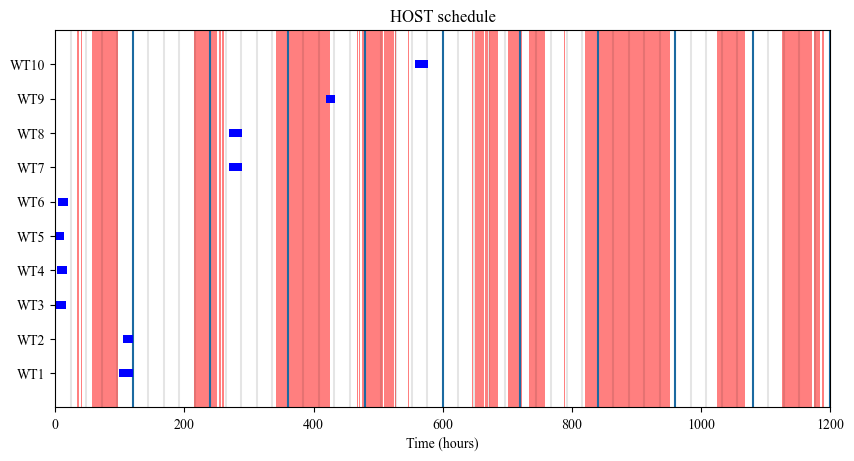

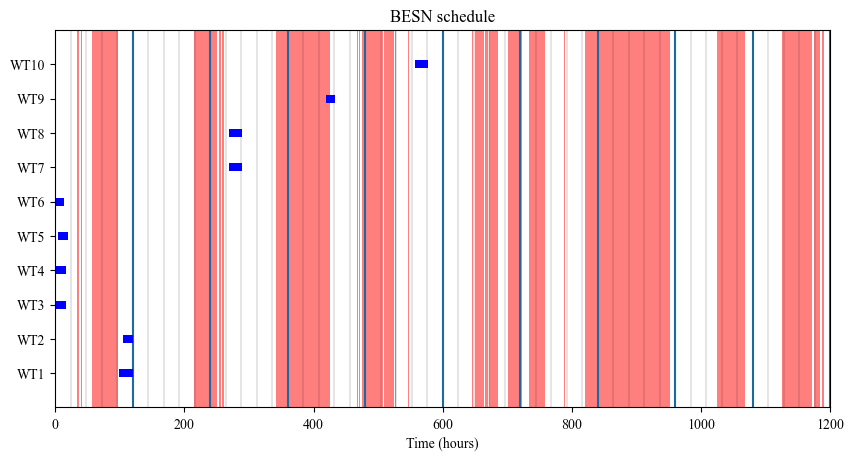

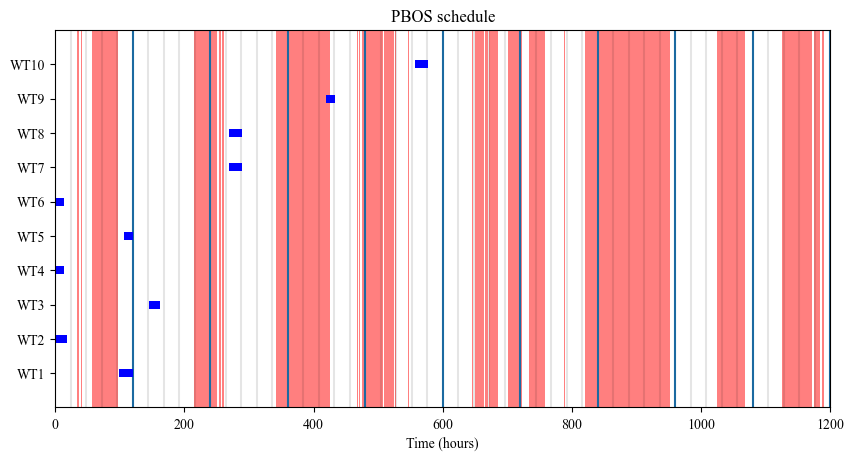

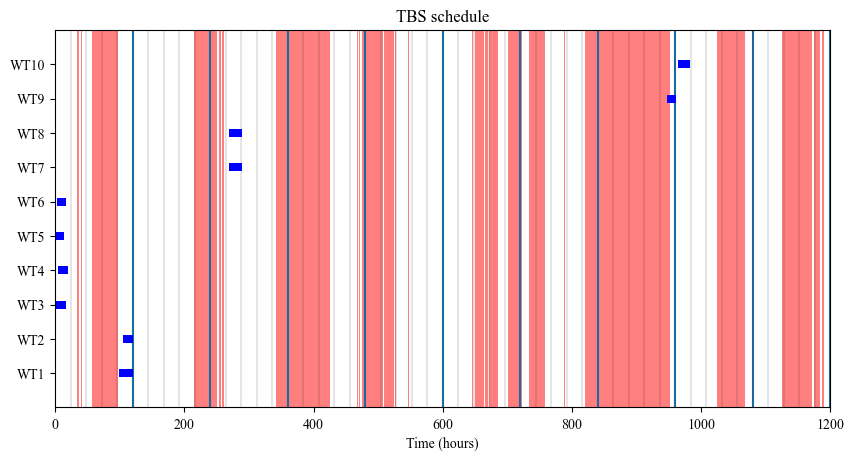

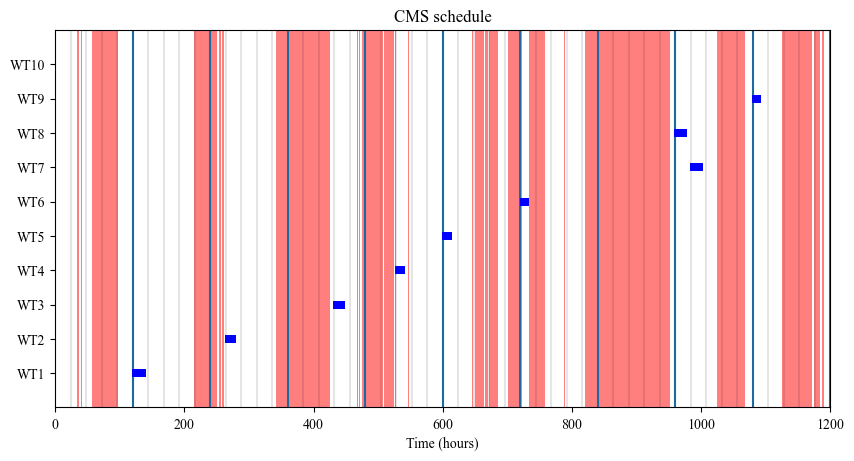

In [35]:
Din = 0 #specify the initial day used by HOST and the benchmarks

visualize_schedule(HOST_sols['Hourly schedules'][2], title = 'HOST schedule')
acessibility_background(Din, opt_hor=50)
plt.xlim([0,1200])

visualize_schedule(BESN_sched[2], title = 'BESN schedule')
acessibility_background(Din, opt_hor=50)
plt.xlim([0,1200])

visualize_schedule(PBOS_sched[2], title = 'PBOS schedule')
acessibility_background(Din, opt_hor=50)
plt.xlim([0,1200])

visualize_schedule(TBS_sched[2], title = 'TBS schedule')
acessibility_background(Din, opt_hor=50)
plt.xlim([0,1200])

visualize_schedule(CMS_sched[2], title = 'CMS schedule')
acessibility_background(Din, opt_hor=50)
plt.xlim([0,1200])

### [Back to Table of Contents](#toc)

# Loading and analysing solutions from externally saved files
<a id='sec_5'></a>

## Case study I
<a id='sec_5_1'></a>

In [14]:
host_metrics = pd.read_excel("HOST.xlsx")
besn_metrics = pd.read_excel("BESN.xlsx")
pbos_metrics = pd.read_excel("PBOS.xlsx")
tbs_metrics = pd.read_excel("TBS.xlsx")
cms_metrics = pd.read_excel("CMS.xlsx")

In [27]:
host_metrics.describe()

,Din,Cost,Ves. Rentals,Ves. Util.,Downtime (h),Prod. Loss (MW),PM,CM
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,14.500000,163038.961000,8.233333,6.800000,153.933333,555.696667,9.833333,2.166667
std,8.803408,39721.491452,1.040004,0.484234,59.910815,497.808402,0.379049,0.379049
min,0.000000,123418.290000,6.000000,6.000000,96.000000,70.850000,9.000000,2.000000
25%,7.250000,131153.272500,8.000000,7.000000,96.000000,143.312500,10.000000,2.000000
50%,14.500000,148248.915000,8.000000,7.000000,138.500000,406.355000,10.000000,2.000000
75%,21.750000,181723.805000,9.000000,7.000000,178.750000,725.652500,10.000000,2.000000
max,29.000000,272592.700000,10.000000,8.000000,298.000000,1926.160000,10.000000,3.000000


In [28]:
besn_metrics.describe()

,Din,Cost,Ves. Rentals,Ves. Util.,Downtime (h),Prod. Loss (MW),PM,CM
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,14.500000,174750.215333,10.333333,6.900000,159.600000,611.461667,9.666667,2.333333
std,8.803408,53608.763930,2.630502,0.661764,69.938199,586.657336,0.479463,0.479463
min,0.000000,125918.290000,6.000000,6.000000,96.000000,88.930000,9.000000,2.000000
25%,7.250000,134050.245000,9.000000,7.000000,97.250000,161.932500,9.000000,2.000000
50%,14.500000,163108.570000,10.000000,7.000000,138.500000,418.520000,10.000000,2.000000
75%,21.750000,188301.770000,11.750000,7.000000,178.750000,729.537500,10.000000,3.000000
max,29.000000,358658.570000,18.000000,9.000000,375.000000,2570.730000,10.000000,3.000000


In [29]:
pbos_metrics.describe()

,Din,Cost,Ves. Rentals,Ves. Util.,Downtime (h),Prod. Loss (MW),PM,CM
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,14.500000,178859.052667,11.800000,8.100000,159.600000,601.886667,9.566667,2.433333
std,8.803408,55078.217203,2.857537,0.844863,69.938199,588.637058,0.626062,0.626062
min,0.000000,127029.280000,8.000000,7.000000,96.000000,75.270000,8.000000,2.000000
25%,7.250000,140639.407500,10.000000,7.250000,97.250000,152.567500,9.000000,2.000000
50%,14.500000,169317.420000,11.000000,8.000000,138.500000,401.120000,10.000000,2.000000
75%,21.750000,192347.957500,13.000000,9.000000,178.750000,729.355000,10.000000,3.000000
max,29.000000,366060.920000,21.000000,10.000000,375.000000,2569.400000,10.000000,4.000000


In [30]:
tbs_metrics.describe()

,Din,Cost,Ves. Rentals,Ves. Util.,Downtime (h),Prod. Loss (MW),PM,CM
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,14.500000,216851.356667,14.233333,11.300000,164.633333,850.709333,8.566667,3.433333
std,8.803408,43798.506052,1.501340,0.749713,63.067825,502.389723,1.135124,1.135124
min,0.000000,158260.040000,11.000000,10.000000,96.000000,238.200000,6.000000,2.000000
25%,7.250000,188665.670000,13.250000,11.000000,105.500000,445.597500,8.000000,3.000000
50%,14.500000,202276.700000,14.000000,11.000000,149.000000,675.755000,9.000000,3.000000
75%,21.750000,245566.240000,15.000000,12.000000,202.000000,1116.260000,9.000000,4.000000
max,29.000000,312774.420000,17.000000,12.000000,298.000000,2153.310000,10.000000,6.000000


In [31]:
cms_metrics.describe()

,Din,Cost,Ves. Rentals,Ves. Util.,Downtime (h),Prod. Loss (MW),PM,CM
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.0,30.0
mean,14.500000,500724.818000,14.633333,10.566667,484.000000,3228.851667,0.0,12.0
std,8.803408,54330.120792,1.473521,0.858360,91.463956,686.426023,0.0,0.0
min,0.000000,401897.050000,12.000000,9.000000,332.000000,2011.210000,0.0,12.0
25%,7.250000,469380.552500,13.000000,10.000000,416.250000,2832.205000,0.0,12.0
50%,14.500000,488426.205000,15.000000,10.000000,468.500000,3077.205000,0.0,12.0
75%,21.750000,521619.815000,16.000000,11.000000,541.500000,3531.182500,0.0,12.0
max,29.000000,653391.510000,17.000000,12.000000,723.000000,5154.890000,0.0,12.0


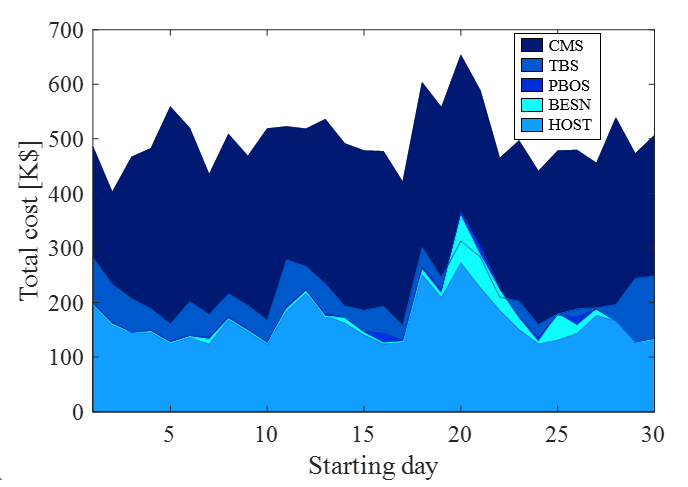

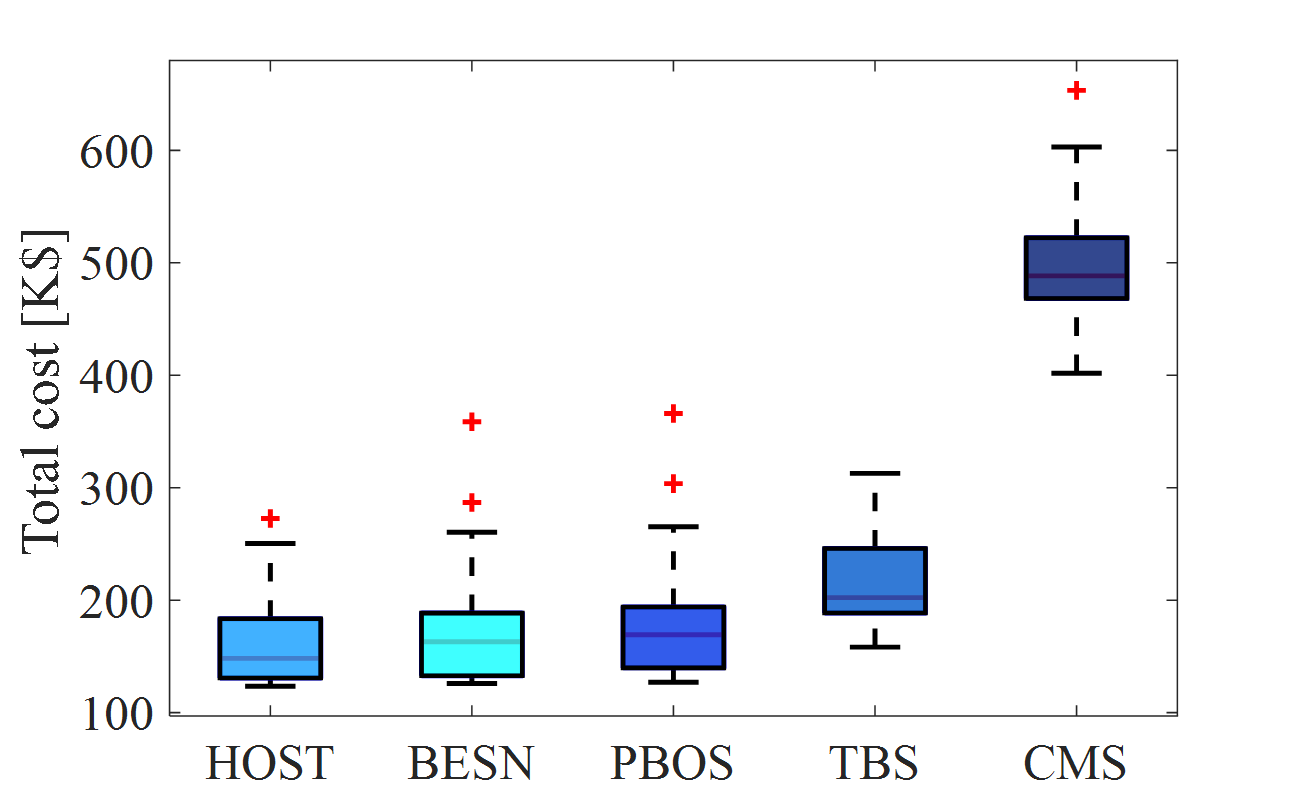

## Case study II
<a id='sec_5_2'></a>

In [15]:
#Solutions for the 2nd case study in the paper
host_sols_10wt_var_price = pickle.load(open("HOST2_10wt_var_price5.json", "rb"))
besn_sols_10wt_var_price = pickle.load(open("BESN2_10wt_var_price5.json", "rb")) 
pbos_sols_10wt_var_price = pickle.load(open("PBOS2_10wt_var_price5.json", "rb")) 
tbs_sols_10wt_var_price = pickle.load(open("TBS2_10wt_var_price5.json", "rb")) 
cms_sols_10wt_var_price = pickle.load(open("CMS2_10wt_var_price5.json", "rb")) 

In [16]:
kpis = "total_profit total_cost vessel_rentals rentals_utilized total_downtime total_prod_loss total_PM total_CM opt_time".split()
num_sols = 30 #number of total optimizations run for the analysis

host_metrics_10wt_var_price = pd.DataFrame([host_sols_10wt_var_price[i]['Metrics'] for i in range(num_sols)], columns = kpis, index = np.arange(num_sols))
besn_metrics_10wt_var_price = pd.DataFrame([besn_sols_10wt_var_price[i]['Metrics'] for i in range(num_sols)], columns = kpis, index = np.arange(num_sols))
pbos_metrics_10wt_var_price = pd.DataFrame([pbos_sols_10wt_var_price[i]['Metrics'] for i in range(num_sols)], columns = kpis, index = np.arange(num_sols))
tbs_metrics_10wt_var_price = pd.DataFrame([tbs_sols_10wt_var_price[i]['Metrics'] for i in range(num_sols)], columns = kpis, index = np.arange(num_sols))
cms_metrics_10wt_var_price = pd.DataFrame([cms_sols_10wt_var_price[i]['Metrics'] for i in range(num_sols)], columns = kpis, index = np.arange(num_sols))

In [52]:
host_metrics_10wt_var_price.describe()

,total_profit,total_cost,vessel_rentals,rentals_utilized,total_downtime,total_prod_loss,total_PM,total_CM,opt_time
count,3.000000e+01,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2.443660e+06,74766.273697,5.366667,4.500000,109.733334,69.474994,9.933333,0.066667,35.238000
std,4.508022e+05,5317.202032,0.927857,0.629724,32.431289,23.907278,0.253708,0.253708,6.885591
min,1.480672e+06,68459.639915,4.000000,4.000000,68.000000,27.726826,9.000000,0.000000,25.720000
25%,2.223213e+06,71013.475461,5.000000,4.000000,76.000000,47.568781,10.000000,0.000000,29.347500
50%,2.411586e+06,73215.836715,5.000000,4.000000,97.000000,70.243960,10.000000,0.000000,33.470000
75%,2.667886e+06,77578.157284,6.000000,5.000000,142.000000,90.102915,10.000000,0.000000,40.652500
max,3.221431e+06,92240.650375,7.000000,6.000000,161.000000,109.580659,10.000000,1.000000,49.830000


In [53]:
besn_metrics_10wt_var_price.describe()

,total_profit,total_cost,vessel_rentals,rentals_utilized,total_downtime,total_prod_loss,total_PM,total_CM,opt_time
count,3.000000e+01,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2.441317e+06,77943.368074,5.633333,4.433333,113.666668,86.285273,9.800000,0.200000,49.738333
std,4.508753e+05,12095.067992,1.272612,0.568321,32.794379,97.202008,0.406838,0.406838,14.225827
min,1.480672e+06,68459.638665,4.000000,4.000000,68.000000,30.850554,9.000000,0.000000,31.300000
25%,2.217712e+06,71013.474523,5.000000,4.000000,76.000002,44.323936,10.000000,0.000000,39.465000
50%,2.411586e+06,73043.647942,5.000000,4.000000,101.000000,65.909354,10.000000,0.000000,48.360000
75%,2.665730e+06,79081.525177,6.000000,5.000000,143.500001,91.140692,10.000000,0.000000,56.417500
max,3.222115e+06,128465.247996,10.000000,6.000000,163.000000,582.489715,10.000000,1.000000,83.750000


In [54]:
pbos_metrics_10wt_var_price.describe()

,total_profit,total_cost,vessel_rentals,rentals_utilized,total_downtime,total_prod_loss,total_PM,total_CM,opt_time
count,3.000000e+01,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2.533008e+06,78758.175856,6.966667,6.200000,115.033334,60.220382,9.800000,0.200000,51.375000
std,4.483117e+05,12274.085449,1.272612,0.805156,31.062211,75.405687,0.484234,0.484234,12.838854
min,1.495395e+06,69449.191432,5.000000,5.000000,76.000000,13.314102,8.000000,0.000000,31.440000
25%,2.355574e+06,72302.466851,6.000000,6.000000,95.000000,27.281377,10.000000,0.000000,40.752500
50%,2.595451e+06,74638.880701,7.000000,6.000000,100.500000,37.078588,10.000000,0.000000,50.025000
75%,2.759082e+06,78985.508763,7.750000,7.000000,143.000000,58.734410,10.000000,0.000000,60.917500
max,3.238693e+06,127406.502830,10.000000,8.000000,162.000000,398.011249,10.000000,2.000000,83.360000


In [55]:
tbs_metrics_10wt_var_price.describe()

,total_profit,total_cost,vessel_rentals,rentals_utilized,total_downtime,total_prod_loss,total_PM,total_CM,opt_time
count,3.000000e+01,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,3.405947e+06,147889.466903,12.400000,5.866667,147.933339,157.295212,5.700000,4.300000,67.095333
std,4.421586e+05,17021.207036,2.357673,1.041661,31.430198,130.830036,1.263547,1.263547,16.634790
min,2.736774e+06,114252.788738,7.999998,4.000000,100.000013,29.622108,3.000000,2.000000,39.870000
25%,3.074841e+06,137450.600740,11.000000,5.000000,126.000000,83.736420,5.000000,4.000000,54.322500
50%,3.504991e+06,150622.889447,12.000000,6.000000,143.500006,117.129532,5.000000,5.000000,67.710000
75%,3.642668e+06,157077.449777,13.750000,7.000000,160.750010,177.561439,6.000000,5.000000,77.107500
max,4.309407e+06,187033.356124,17.000000,8.000000,261.000000,671.902098,8.000000,7.000000,106.710000


In [56]:
cms_metrics_10wt_var_price.describe()

,total_profit,total_cost,vessel_rentals,rentals_utilized,total_downtime,total_prod_loss,total_PM,total_CM,opt_time
count,3.000000e+01,30.000000,30.000000,30.000000,30.000000,30.000000,30.0,30.0,30.000000
mean,4.595140e+06,324222.398213,11.100000,9.933333,553.466667,2019.660538,0.0,10.0,73.385333
std,2.394325e+05,28304.200183,0.884736,0.253708,76.337605,454.233927,0.0,0.0,3.208852
min,4.163937e+06,276417.903442,10.000000,9.000000,423.000000,1282.022818,0.0,10.0,68.490000
25%,4.454855e+06,303353.465473,11.000000,10.000000,492.750000,1662.546624,0.0,10.0,70.765000
50%,4.526788e+06,319291.883213,11.000000,10.000000,548.000000,1950.932466,0.0,10.0,73.130000
75%,4.737819e+06,346945.305093,11.750000,10.000000,611.000000,2392.452196,0.0,10.0,75.540000
max,5.198336e+06,387062.694061,14.000000,10.000000,686.000000,3033.932441,0.0,10.0,81.170000


(0.0, 29.0)

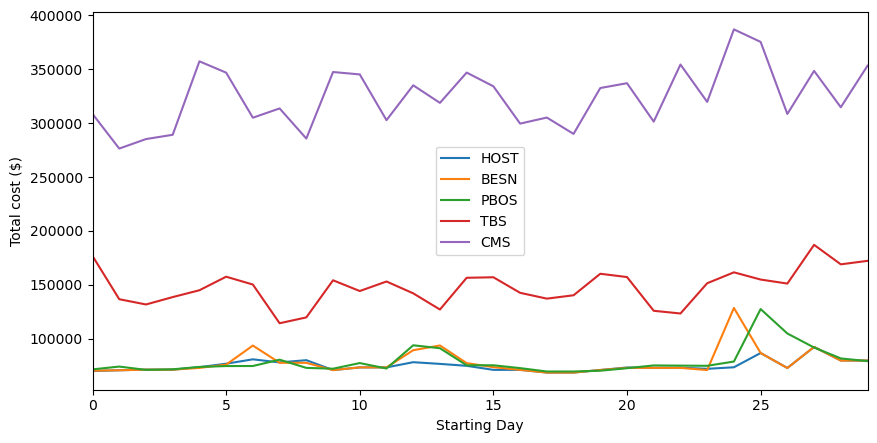

In [51]:
plt.figure(figsize = (10,5), dpi = 100)
plt.plot(host_metrics_10wt_var_price['total_cost'])
plt.plot(besn_metrics_10wt_var_price['total_cost'])
plt.plot(pbos_metrics_10wt_var_price['total_cost'])
plt.plot(tbs_metrics_10wt_var_price['total_cost'])
plt.plot(cms_metrics_10wt_var_price['total_cost'])
plt.legend("HOST BESN PBOS TBS CMS".split())
plt.ylabel('Total cost ($)')
plt.xlabel('Starting Day')
plt.xlim([0, 29])

### [Back to Table of Contents](#toc)

# Sensitivity analysis of the hourly scale
<a id='sec_6'></a>

We compare the optimal schedule against all sub-optimal schedules obtained by shifting the start time of the maintenance tasks to different hourly slots within a day. Two sets of comparisons are performed: (i) when access constraints are relaxed (\# of feasible solutions per day $\approxeq 5,000$), and (ii) when access constraints hold (\# of feasible solutions vary per day depending on access states).

In [21]:
NWT = 3 # Number of wind turbines
np.random.seed(0)
wind_speeds = np.random.normal(loc=wind_speed_hourly, scale=1, size=(wind_speed_hourly.shape[0],NWT)).reshape(-1,24,NWT) #generate random wind speed profiles for the 3 wind turbines of shape (num_days, 24, NWT)
wave_height = wave_height_hourly.reshape(-1,24) #shape=(num_days, 24)

fw2 = np.zeros_like(wind_speeds) #Colculate normalized power using the binning method
for j in range(ws_bin_processed.index.shape[0]-1):
    index_true_STH = (wind_speeds>=ws_bin_processed['Wind speed bins'][j]) & (
        wind_speeds<ws_bin_processed['Wind speed bins'][j+1])
    fw2[index_true_STH] = ws_bin_processed['Norm power'][j]

electricity_price = sys_en_price_data[:wind_speed_hourly.shape[0]].reshape(-1,24) #reshape hourly electricity price to (num_days, 24)
hourly_revenue2 = 12*fw2*electricity_price[:,:,None] #revenue=Rated_power*Normalized_power_output*Electricity_price

revenue_lost_ex1 = np.zeros((101,24-7,NWT)) #revenue loss for 7-hour maintenance tasks
for i in range(24-7):
    revenue_lost_ex1[:,i] = np.sum(hourly_revenue2[:,i:i+7,:],1)/1000

best_sol_ex1 = revenue_lost_ex1.min(1).sum(-1) #least cost solution for each day
worst_sol_ex1 = revenue_lost_ex1.max(1).sum(-1) #highest cost solution for each day

count = 0
idx_combs = np.zeros((101,17**3,NWT),dtype=np.int32) #calculate all possible index combinations to find all solutions
for i in range(17):
    for j in range(17):
        for k in range(17):
            idx_combs[:,count,:] = np.tile(np.array([i,j,k],dtype=np.int32),(101,1))
            count += 1
            
rev_loss_combs = np.zeros((101,idx_combs.shape[1])) #calculate all possible solutions for one day
for i in range(idx_combs.shape[1]):
    for j in range(101):
        rev_loss_combs[j,i] = np.sum(revenue_lost_ex1[j,idx_combs[j,i,:], np.arange(NWT)], -1)
        
labels_x = [] # labels to be used in the figure
for i in range(101):
    if i%10==0:
        labels_x.append(str(i))
    else:
        labels_x.append(' ')

Cost ranges for the mixed set of soltions (i.e. unlimited resources)


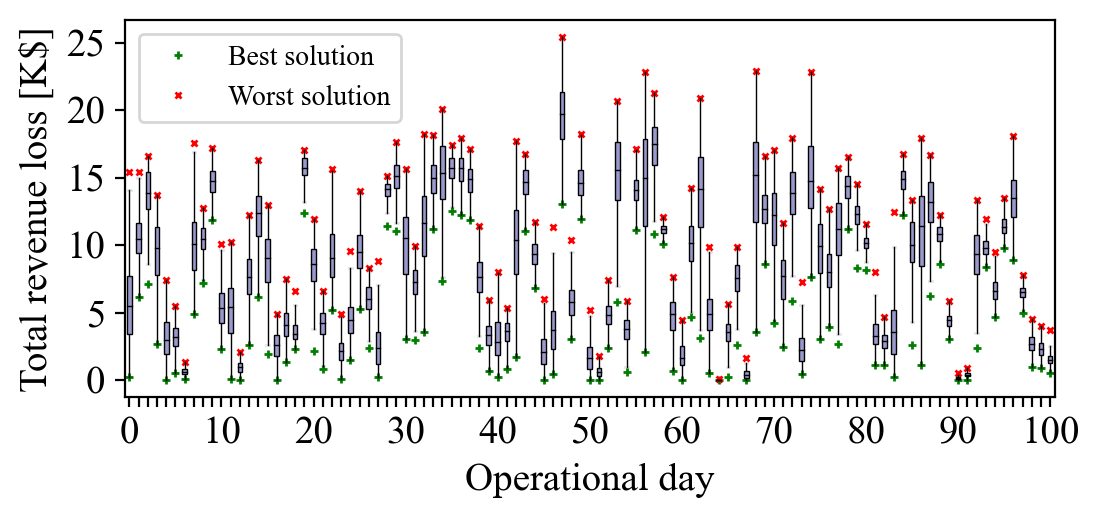

In [19]:
axis_font = {'fontname':'Times New Roman', 'size':'14'}
plt.rc('font',family='Times New Roman')
plt.figure(figsize = (6,2.5), dpi=200)

plt.plot(np.arange(1,102), best_sol_ex1, 'g+', markersize=3)
plt.plot(np.arange(1,102), worst_sol_ex1, 'rx',  markersize=2)

plt.boxplot(rev_loss_combs.T, sym='+', showfliers=False, labels=labels_x, 
            notch=False, vert=True, patch_artist=True, boxprops=dict(facecolor=[0.6,0.6,0.8], color='k', lw=0.5),
            medianprops=dict(color='k', lw=0.5),whiskerprops=dict(lw=0.5),capprops=dict(alpha=0.1))
plt.xticks(**axis_font)
plt.yticks(**axis_font)
plt.xlabel('Operational day', **axis_font)
plt.ylabel('Total revenue loss [K\$]', **axis_font)

plt.legend(['Best solution', 'Worst solution'])

print('Cost ranges for the mixed set of soltions (i.e. unlimited resources)')

In [23]:
revenue_lost_ex2 = revenue_lost_ex1
accessible_logical = np.full_like(revenue_lost_ex2, False) #create a boolean map for feasible solutions
for i in range(24-7):
    for j in range(NWT):
        for k in range(101):
            if (np.all(wind_speeds[k,i:i+7,j]<15)) and (np.all(wave_height[k,i:i+7]<1.5)):
                accessible_logical[k,i,j] = True
                
rev_loss_combs2 = np.zeros((101,rev_loss_combs.shape[1]))
for i in range(rev_loss_combs.shape[1]):
    for j in range(101):
        rev_loss_combs2[j,i] = np.sum(revenue_lost_ex2[j,idx_combs[j,i,:], np.arange(NWT)], -1)
        if not(all(accessible_logical[j,idx_combs[j,i,:], np.arange(NWT)])):
            rev_loss_combs2[j,i] = np.nan #replace with NaN the infeasible time slots
            
where_nan = np.isnan(rev_loss_combs2) #boolean map for NaNs
rev_loss_combs2_list = [rev_loss_combs2[i,~where_nan[i,:]] for i in range(101)] #a list with each element being a numpy array with feasible solutions. Each array is different size

conf_intervals = np.empty((101,2)) #1st column: best solutions, 2nd column: worst solutions
cost_difference = np.full((101,1),np.nan) #range of costs
feasible_days = np.full((101,1),False) #boolean array: False when a day has not any feasible solutions
for i in range(101):
    if rev_loss_combs2_list[i].size == 0: #if the day of the list has no solutions
        conf_intervals[i,0] = np.nan
        conf_intervals[i,1] = np.nan
    else: #if there is at least one solution
        conf_intervals[i,0] = np.min(rev_loss_combs2_list[i]) 
        conf_intervals[i,1] = np.max(rev_loss_combs2_list[i])
        cost_difference[i,0] = conf_intervals[i,1] - conf_intervals[i,0]
        feasible_days[i,0] = True

Cost ranges for the feasible set of soltions (i.e. constrained by the accessibility)


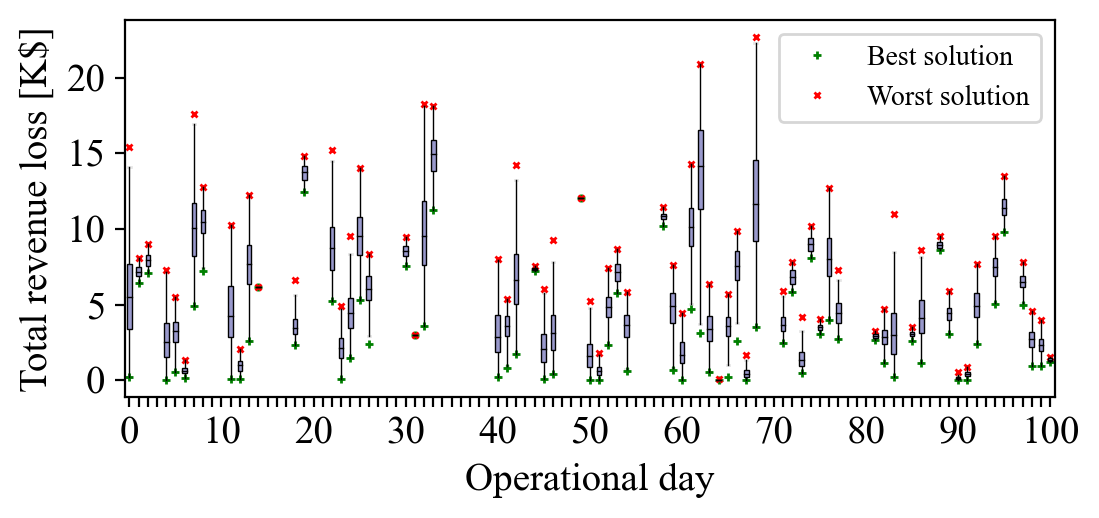

In [65]:
axis_font = {'fontname':'Times New Roman', 'size':'14'}
plt.rc('font',family='Times New Roman')
plt.figure(figsize = (6,2.5), dpi=200)

plt.plot(np.arange(1,102), conf_intervals[:,0], 'g+', markersize=3)
plt.plot(np.arange(1,102), conf_intervals[:,1], 'rx',  markersize=2)

plt.boxplot(rev_loss_combs2_list, sym='+', showfliers=False, conf_intervals=conf_intervals, labels=labels_x, 
            notch=False, vert=True, patch_artist=True, boxprops=dict(facecolor=[0.6,0.6,0.8], color='k', lw=0.5),
            medianprops=dict(color='k', lw=0.5),whiskerprops=dict(lw=0.5),capprops=dict(alpha=0.1))
plt.xticks(**axis_font)
plt.yticks(**axis_font)
plt.xlabel('Operational day', **axis_font)
plt.ylabel('Total revenue loss [K\$]', **axis_font)

plt.legend(['Best solution', 'Worst solution'])

print('Cost ranges for the feasible set of soltions (i.e. constrained by the accessibility)')

### [Back to Table of Contents](#toc)